# Analyzing RNA-seq data in the dorsal root ganglion neurons with limma, Glimma and edgeR

##  Abstract
The ability to easily and efficiently analyse RNA-sequencing data is a key strength of the Bioconductor project. Starting with counts summarised at the gene-level, a typical analysis involves pre-processing, exploratory data analysis, differential expression testing and pathway analysis with the results obtained informing future experiments and validation studies. In this workflow article, we analyse RNA-sequencing data from the dorsal root ganglion neurons to unveil pain-related gene regulated by a human cellular tissue product. We demonstrate the use of the popular ***edgeR*** package to import, organise, filter and normalise the data, followed by the ***limma*** package with its voom method, linear modelling and empirical Bayes moderation to assess differential expression. This pipeline is further enhanced by minimizing the technical variations between each sets/batches by ComBat-seq package or the EdgeR package using the design formula (~batch + condition). 

##  Introduction
Gene expression is a highly regulated mechanism that controls the function and adaptability of all living cells including prokaryotes and eukaryotes. Several techniques exist for studying and quantifying gene expression and its regulation. Among various techniques deployed to assess gene expression, RNA-seq can provide qualitative (RNA sequence) and quantitative (RNA abundance) analyses of either targeted mRNA transcripts or the complete transcriptome of a particular issue. Transcriptomic data analysis can be performed using data obtained from a standard bulk RNA-seq. This tutorial describe the main steps to perform differential expression analysis (DEA). This is a brief introduction that covers the main aspects of DEA and outlines the most common types of analyses in this type of studies. The complete analysis also highlights the ease with which researchers can turn the raw counts from an RNA-sequencing experiment into biological insights using Bioconductor.

## Set-up

In [1]:
# First, let's load all the packages we will need to analyse the data.
library(edgeR)
library(ggplot2)
library(Glimma)
library(gplots)
library(here)
library(limma)
library(NMF)
library(org.Mm.eg.db)
library(RColorBrewer)
library(statmod)
library(sva)
library(tidyverse)

Loading required package: limma


Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess


here() starts at C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq

Loading required package: pkgmaker

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: windows] | Cores 11/12

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: IRanges

Loading required package: S4Vectors


Attaching package: 'S4Vectors'


The following object is masked from 'package:NMF':

    nrun


The following object is masked from 'package:pkgmaker':

    new2


The following object is masked from 'package:gplots':

    space


The following objects are masked from 'package:base':

    expand.grid, I, unname



Attaching package: 'IRanges'


The following object is masked from 'package:grDevices

## Data packaging

###  Reading in count-data
In the below, we first generate a ***DGEList-object*** from the count matrix.

In [4]:
filename <- here()
filename
filename <- here(filename, "input/HHP_2h_24h_WT/")

[1] "C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq"

In [10]:
list.files(filename, recursive = TRUE)  # list all the files in this directory

[1] "10min_1_counts.txt"                     
 [2] "10min_2_counts.txt"                     
 [3] "10min_3_counts.txt"                     
 [4] "24h_1_counts.txt"                       
 [5] "24h_2_counts.txt"                       
 [6] "24h_3_counts.txt"                       
 [7] "2h_1_counts.txt"                        
 [8] "2h_2_counts.txt"                        
 [9] "2h_3_counts.txt"                        
[10] "Control_1_counts.txt"                   
[11] "Control_2_counts.txt"                   
[12] "Control_3_counts.txt"                   
[13] "New count/CZha-24hr-1_S4.featureCounts" 
[14] "New count/CZha-24Hr-2_S9.featureCounts" 
[15] "New count/CZha-24Hr-3_S10.featureCounts"
[16] "New count/CZha-Cont-1_S1.featureCounts" 
[17] "New count/CZha-Cont-2_S11.featureCounts"
[18] "New count/CZha-Cont-3_S12.featureCounts"
[19] "New count/SampleInfo_without2h10min.txt"
[20] "SampleInfo.txt"                         
[21] "SampleInfo_without2h10min.txt"

Each of these text files contains the raw gene-level counts for a given sample. Note that our analysis only includes the Contol and HHP24h samples from this experiment (see associated file names below).

In [18]:
sampleinfo <- read.delim(here(filename, "/SampleInfo_without2h10min.txt"), stringsAsFactors = TRUE)
# sampleinfo <- read.delim('./SampleInfo_without2h10min.txt', stringsAsFactors
# = TRUE) # read for google colab
sampleinfo  # with treatment and batch information

FileName,SampleName,Treatment,Batch
<fct>,<fct>,<fct>,<fct>
Control_1_counts,CON_1,control,first
Control_2_counts,CON_2,control,second
Control_3_counts,CON_3,control,third
24h_1_counts,HHP.24H_1,hhp.24hr,first
24h_2_counts,HHP.24H_2,hhp.24hr,second
24h_3_counts,HHP.24H_3,hhp.24hr,third


In [13]:
files <- c("Control_1_counts.txt", "Control_2_counts.txt", "Control_3_counts.txt",
    "24h_1_counts.txt", "24h_2_counts.txt", "24h_3_counts.txt")
# all the files
read.delim(here(filename, files[1]), nrow = 5)  # test first file
# read.delim(here(filename, './', files[1]), nrow = 5) # test first file counts
# file with geneid and counts

Geneid,RNA.STAR.on.data.191..data.172..and.data.171..mapped.bam
<chr>,<int>
Xkr4,2502
Gm39585,1
Gm38717,31
Rp1,0
Sox17,161


Whilst each of the six text files can be read into R separately and combined into a matrix of counts, edgeR offers a convenient way to do this in one step using the readDGE function. The resulting DGEList-object contains a matrix of counts with 35,976 rows associated with unique Entrez gene identifiers (IDs) and six columns associated with the individual samples in the experiment.

In [16]:
x <- readDGE(here(filename, files), columns = c(1, 2))
# x <- readDGE(here(filename, './', files), columns = c(1, 2)) create DGE
# objects with 9 the counts files, only two columns
head(x)  # x with samples, counts, 
class(x)
dim(x)
names(x)

An object of class "DGEList"
$samples
                                                                                                                                                                                                                      files
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_1_counts C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_1_counts.txt
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_2_counts C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_2_counts.txt
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_3_counts C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_3_counts.txt
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_1_counts         C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_1_counts.txt
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_2_counts         C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_2_counts.txt
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_3_counts         C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_3_counts.txt
                                                                                                            group
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_1_counts     1
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_2_counts     1
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_3_counts     1
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_1_counts         1
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_2_counts         1
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_3_counts         1
                                                                                                            lib.size
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_1_counts 42516054
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_2_counts 42617496
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_3_counts 54117547
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_1_counts     37998071
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_2_counts     37434266
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_3_counts     38420247
                                                                                                            norm.factors
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_1_counts            1
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_2_counts            1
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_3_counts            1
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_1_counts                1
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_2_counts                1
C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HH

[1] "DGEList"
attr(,"package")
[1] "edgeR"

[1] 35976     6

[1] "samples" "counts"

### Organising sample information 
For downstream analysis, sample-level information related to the experimental design needs to be associated with the columns of the counts matrix. This should include experimental variables, both biological and technical, that could have an effect on expression levels. Examples include cell type, genotype (wild-type, knock-out), phenotype (disease status, sex, age), sample treatment (drug, control) and batch information (date experiment was performed if samples were collected and analysed at distinct time points) to name just a few.

Our DGEList-object contains a samples data frame that stores both cell type (or group) and batch (sequencing lane) information, each of which consists of three distinct levels. Note that within x$samples, library sizes are automatically calculated for each sample and normalisation factors are set to 1. For simplicity, we remove the GEO sample IDs (GSM*) from the column names of our DGEList-object x.

In [19]:
sampleinfo$SampleName

[1] CON_1     CON_2     CON_3     HHP.24H_1 HHP.24H_2 HHP.24H_3
Levels: CON_1 CON_2 CON_3 HHP.24H_1 HHP.24H_2 HHP.24H_3

In [20]:
colnames(x) <- sampleinfo$SampleName

In [21]:
x$samples  # x, DGE objects with sample and counts dataframes
head(x$counts)

,files,group,lib.size,norm.factors
,<chr>,<fct>,<dbl>,<dbl>
CON_1,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_1_counts.txt,1,42516054,1
CON_2,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_2_counts.txt,1,42617496,1
CON_3,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_3_counts.txt,1,54117547,1
HHP.24H_1,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_1_counts.txt,1,37998071,1
HHP.24H_2,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_2_counts.txt,1,37434266,1
HHP.24H_3,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_3_counts.txt,1,38420247,1


,CON_1,CON_2,CON_3,HHP.24H_1,HHP.24H_2,HHP.24H_3
Xkr4,2502,1912,2264,1682,1262,1342
Gm39585,1,0,2,0,0,0
Gm38717,31,39,15,37,43,10
Rp1,0,0,1,1,0,0
Sox17,161,234,335,189,199,202
LOC108167609,0,1,0,2,0,3


In [22]:
group <- sampleinfo$Treatment
# Take a look
group
# Add the group information into the DGEList
x$samples$group <- group
x$samples

[1] control  control  control  hhp.24hr hhp.24hr hhp.24hr
Levels: control hhp.24hr

,files,group,lib.size,norm.factors
,<chr>,<fct>,<dbl>,<dbl>
CON_1,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_1_counts.txt,control,42516054,1
CON_2,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_2_counts.txt,control,42617496,1
CON_3,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_3_counts.txt,control,54117547,1
HHP.24H_1,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_1_counts.txt,hhp.24hr,37998071,1
HHP.24H_2,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_2_counts.txt,hhp.24hr,37434266,1
HHP.24H_3,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_3_counts.txt,hhp.24hr,38420247,1


### Organising gene annotations
A second data frame named genes in the DGEList-object is used to store gene-level information associated with rows of the counts matrix. This information can be retrieved using organism specific packages such as Mus.musculus (Bioconductor Core Team 2016b) for mouse or the biomaRt package (Durinck et al. 2005, 2009) which interfaces the Ensembl genome databases in order to perform gene annotation.

The type of information that can be retrieved includes gene symbols, gene names, chromosome names and locations, Entrez gene IDs, Refseq gene IDs and Ensembl gene IDs to name just a few. biomaRt primarily works off Ensembl gene IDs, whereas Mus.musculus packages information from various sources and allows users to choose between many different gene IDs as the key.

The Entrez gene IDs available in our dataset were annotated using the Mus.musculus package to retrieve associated gene symbols and chromosome information.

In [23]:
# Annotate the genes.
head(x$counts)
dim(x$counts)
geneid <- rownames(x)
genes <- AnnotationDbi::select(org.Mm.eg.db, keys = geneid, columns = c("ENTREZID",
    "SYMBOL", "GENENAME"), keytype = "SYMBOL")
# retrieve the ENTRZIS, GENENAME based on the SYMBOL keytype
head(genes)
genes <- genes[!duplicated(genes$ENTREZID), ]

,CON_1,CON_2,CON_3,HHP.24H_1,HHP.24H_2,HHP.24H_3
Xkr4,2502,1912,2264,1682,1262,1342
Gm39585,1,0,2,0,0,0
Gm38717,31,39,15,37,43,10
Rp1,0,0,1,1,0,0
Sox17,161,234,335,189,199,202
LOC108167609,0,1,0,2,0,3


[1] 35976     6

'select()' returned 1:1 mapping between keys and columns



,SYMBOL,ENTREZID,GENENAME
,<chr>,<chr>,<chr>
1,Xkr4,497097,X-linked Kx blood group related 4
2,Gm39585,105243853,"predicted gene, 39585"
3,Gm38717,NA,NA
4,Rp1,19888,retinitis pigmentosa 1 (human)
5,Sox17,20671,SRY (sex determining region Y)-box 17
6,LOC108167609,NA,NA


As with any gene ID, Entrez gene IDs may not map one-to-one to the gene information of interest. It is important to check for duplicated gene IDs and to understand the source of duplication before resolving them.

In [24]:
x <- x[genes$SYMBOL, ]  # keep only the genes with corresponding SYMBOLs in genes
head(x)

An object of class "DGEList"
$samples
                                                                                                                    files
CON_1     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_1_counts.txt
CON_2     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_2_counts.txt
CON_3     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_3_counts.txt
HHP.24H_1     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_1_counts.txt
HHP.24H_2     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_2_counts.txt
HHP.24H_3     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_3_counts.txt
             group lib.size norm.factors
CON_1      control 42516054            1
CON_2      control 42617496            1
CON_3      control 54117547            1
HHP.24H_1 hhp.24hr 37998071            1
HHP.24H_2 hhp.24hr 37434266            1
HHP.24H_3 hhp.24hr 38420247            1

$counts
         Samples
Tags      CON_1 CON_2 CON_3 HHP.24H_1 HHP.24H_2 HHP.24H_3
  Xkr4     2502  1912  2264      1682      1262      1342
  Gm39585     1     0     2         0         0         0
  Gm38717    31    39    15        37        43        10
  Rp1         0     0     1         1         0         0
  Sox17     161   234   335       189       199       202
  Gm39586     1     0     0         0         1         1

In [25]:
x$genes <- genes  # add genes annotation to x
head(x)  # x has samples, counts, genes annotation attributes
table(genes$SYMBOL == rownames(x))  # test the genes and x rownames are the same
# 32879 genes total

An object of class "DGEList"
$samples
                                                                                                                    files
CON_1     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_1_counts.txt
CON_2     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_2_counts.txt
CON_3     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_3_counts.txt
HHP.24H_1     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_1_counts.txt
HHP.24H_2     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_2_counts.txt
HHP.24H_3     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_3_counts.txt
             group lib.size norm.factors
CON_1      control 42516054            1
CON_2      control 42617496            1
CON_3      control 54117547            1
HHP.24H_1 hhp.24hr 37998071            1
HHP.24H_2 hhp.24hr 37434266            1
HHP.24H_3 hhp.24hr 38420247            1

$counts
         Samples
Tags      CON_1 CON_2 CON_3 HHP.24H_1 HHP.24H_2 HHP.24H_3
  Xkr4     2502  1912  2264      1682      1262      1342
  Gm39585     1     0     2         0         0         0
  Gm38717    31    39    15        37        43        10
  Rp1         0     0     1         1         0         0
  Sox17     161   234   335       189       199       202
  Gm39586     1     0     0         0         1         1

$genes
   SYMBOL  ENTREZID                              GENENAME
1    Xkr4    497097     X-linked Kx blood group related 4
2 Gm39585 105243853                 predicted gene, 39585
3 Gm38717      <NA>                                  <NA>
4     Rp1     19888        retinitis pigmentosa 1 (human)
5   Sox17     20671 SRY (sex determining region Y)-box 17
7 Gm39586 105243854                 predicted gene, 39586


 TRUE 
32773 

In this example, the gene order is the same in both the annotation and the data object. If this is not the case due to missing and/or rearranged gene IDs, the match function can be used to order genes correctly. The data frame of gene annotations is then added to the data object and neatly packaged in a DGEList-object containing raw count data with associated sample information and gene annotations.

In [26]:
# save the raw count maxtrix before batch correction
saveRDS(x, "./x_without_correction.RDS")

## Batch effect correction with ComBat-seq
Because the plotting of the gene loadings showed some batch effects, we minimized the technical variations between each batch during the differential expression analysis by using ComBat-seq package or the EdgeR package, which have been commonly used in previous studies.

ComBat-seq is a batch effect adjustment tool for bulk RNA-seq count data. It is an improved model based on the popular ComBat, to address its limitations through novel methods designed specifically for RNA-Seq studies. ComBat-seq takes untransformed, raw count matrix as input. Same as ComBat, it requires a known batch variable.

In [27]:
# use ComBat-seq to correct batch effect, keep the counts
treatment = c("control", "control", "control", "hhp.24hr", "hhp.24hr", "hhp.24hr")
batch = c("first", "second", "third",  "first", "second", "third")

In [28]:
groups = sapply(as.character(treatment), switch, control = 1, hhp.24hr = 2, USE.NAMES = F)
batches = sapply(as.character(batch), switch, first = 1, second = 2, third = 3, USE.NAMES = F)
# create levels to compare

In [29]:
groups
batches

[1] 1 1 1 2 2 2

[1] 1 2 3 1 2 3

In [30]:
x_corrected_counts <- ComBat_seq(counts = as.matrix(x), batch = batches, group = groups)
# transform counts

Found 3 batches
Using full model in ComBat-seq.
Adjusting for 1 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


In [31]:
head(x$counts)
head(x_corrected_counts)

,CON_1,CON_2,CON_3,HHP.24H_1,HHP.24H_2,HHP.24H_3
Xkr4,2502,1912,2264,1682,1262,1342
Gm39585,1,0,2,0,0,0
Gm38717,31,39,15,37,43,10
Rp1,0,0,1,1,0,0
Sox17,161,234,335,189,199,202
Gm39586,1,0,0,0,1,1


,CON_1,CON_2,CON_3,HHP.24H_1,HHP.24H_2,HHP.24H_3
Xkr4,2078,2084,2527,1398,1364,1479
Gm39585,1,0,2,0,0,0
Gm38717,23,24,33,28,26,24
Rp1,0,0,1,1,0,0
Sox17,191,224,298,221,187,184
Gm39586,1,0,0,0,1,1


In [32]:
x$counts <- x_corrected_counts

In [33]:
saveRDS(x, "./x_with_correction.RDS")

### Pre-filtering
While it is not necessary to pre-filter low count genes before running the functions, there are two reasons which make pre-filtering useful: by removing rows in which there are very few reads, we reduce the memory size of the dds data object, and we increase the speed of the transformation and testing functions within analysis. It can also improve visualizations, as features with no information for differential expression are not plotted.

Here we perform a minimal pre-filtering to keep only rows that have at least 10 reads total. Note that more strict filtering to increase power is automatically applied via independent filtering on the mean of normalized counts within the results function.

In [34]:
# Filtering lowly expressed genes Obtain CPMs
myCPM <- cpm(x)
# Have a look at the output
head(myCPM)
# Which values in myCPM are greater than 0.33?  A CPM of 0.33 is used as it
# corresponds to a count of 10-15 for the library sizes in this data set.  If
# the count is any smaller, it is considered to be very low, indicating that
# the associated gene is not expressed in that sample.  Let's have a look and
# see whether our threshold of 0.33 does indeed correspond to a count of about
# 10-15 We will look at the first sample
thresh <- myCPM > 0.33
# This produces a logical matrix with TRUEs and FALSEs
head(thresh)
# Summary of how many TRUEs there are in each row There are 11433 genes that
# have TRUEs in all 12 samples.
table(rowSums(thresh))
# we would like to keep genes that have at least 2 TRUES in each row of thresh
keep <- rowSums(thresh) >= 2
table(keep)

,CON_1,CON_2,CON_3,HHP.24H_1,HHP.24H_2,HHP.24H_3
Xkr4,48.87565530,48.900104,46.69465155,36.79134133,36.43720435,38.49532774
Gm39585,0.02352053,0.000000,0.03695659,0.00000000,0.00000000,0.00000000
Gm38717,0.54097212,0.563149,0.60978374,0.73687951,0.69455082,0.62467063
Rp1,0.00000000,0.000000,0.01847830,0.02631713,0.00000000,0.00000000
Sox17,4.49242067,5.256057,5.50653192,5.81608472,4.99542318,4.78914152
Gm39586,0.02352053,0.000000,0.00000000,0.00000000,0.02671349,0.02602794


,CON_1,CON_2,CON_3,HHP.24H_1,HHP.24H_2,HHP.24H_3
Xkr4,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
Gm39585,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
Gm38717,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
Rp1,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
Sox17,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
Gm39586,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE



    0     1     2     3     4     5     6 
15668   390   267   421   263   354 15410 

keep
FALSE  TRUE 
16058 16715 

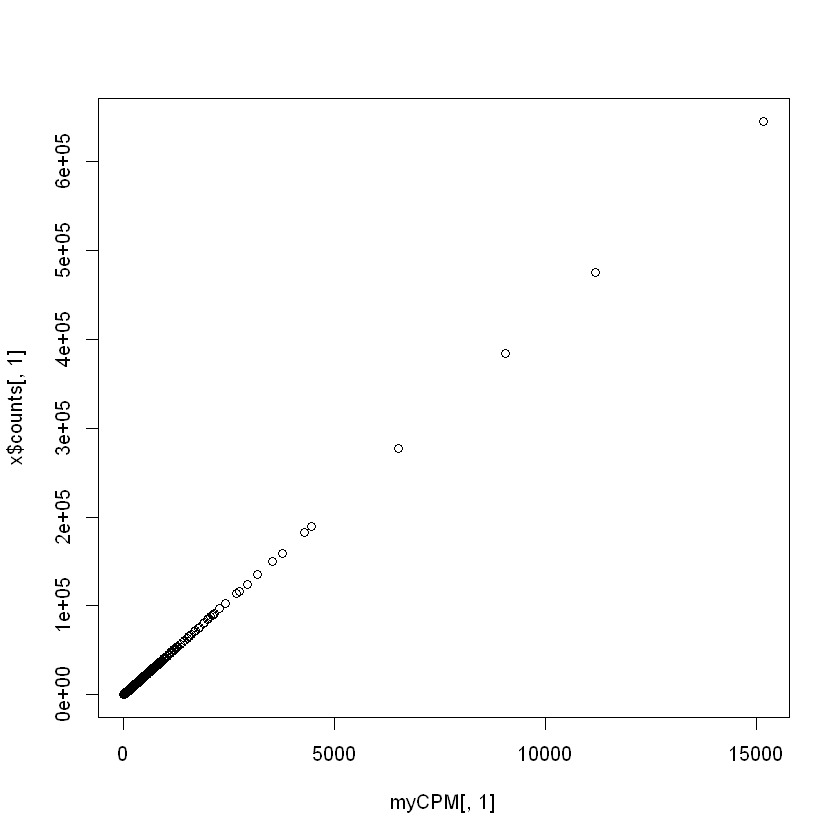

In [35]:
plot(myCPM[, 1], x$counts[, 1])
# Let us limit the x and y-axis so we can actually look to see what is
# happening at the smaller counts

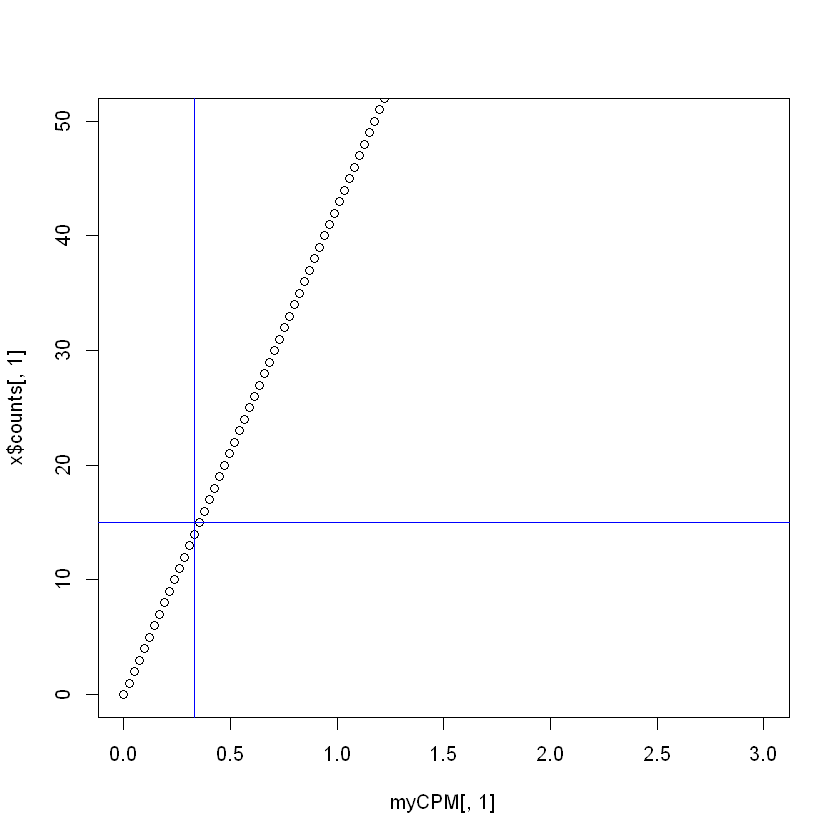

In [36]:
plot(myCPM[, 1], x$counts[, 1], ylim = c(0, 50), xlim = c(0, 3))
# Add a vertical line at 0.5 CPM
abline(v = 0.33, h = 15, col = "blue")
# Now that we've checked our filtering method we will filter the DGEList
# object.)  Let us limit the x and y-axis so we can actually look to see what
# is happening at the smaller counts

In [37]:
# Now that we've checked our filtering method we will filter the DGEList
# object.
x <- x[keep, keep.lib.sizes = FALSE]

In [38]:
dim(x)
head(x)

[1] 16715     6

An object of class "DGEList"
$samples
                                                                                                                    files
CON_1     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_1_counts.txt
CON_2     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_2_counts.txt
CON_3     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_3_counts.txt
HHP.24H_1     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_1_counts.txt
HHP.24H_2     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_2_counts.txt
HHP.24H_3     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_3_counts.txt
             group lib.size norm.factors
CON_1      control 40903070            1
CON_2      control 40768747            1
CON_3      control 52504852            1
HHP.24H_1 hhp.24hr 36777977            1
HHP.24H_2 hhp.24hr 36030235            1
HHP.24H_3 hhp.24hr 36947812            1

$counts
         Samples
Tags      CON_1 CON_2 CON_3 HHP.24H_1 HHP.24H_2 HHP.24H_3
  Xkr4     2078  2084  2527      1398      1364      1479
  Gm38717    23    24    33        28        26        24
  Sox17     191   224   298       221       187       184
  Mrpl15    992  1018  1380       896       856       828
  Lypla1   1715  1684  2188      1380      1376      1393
  Tcea1    3599  3443  4685      2810      2874      2777

$genes
    SYMBOL ENTREZID                                  GENENAME
1     Xkr4   497097         X-linked Kx blood group related 4
3  Gm38717     <NA>                                      <NA>
5    Sox17    20671     SRY (sex determining region Y)-box 17
10  Mrpl15    27395       mitochondrial ribosomal protein L15
11  Lypla1    18777                       lysophospholipase 1
13   Tcea1    21399 transcription elongation factor A (SII) 1

### Normalising gene expression distributions
During the sample preparation or sequencing process, external factors that are not of biological interest can affect the expression of individual samples. For example, samples processed in the first batch of an experiment can have higher expression overall when compared to samples processed in a second batch. It is assumed that all samples should have a similar range and distribution of expression values. Normalisation is required to ensure that the expression distributions of each sample are similar across the entire experiment.

Any plot showing the per sample expression distributions, such as a density or boxplot, is useful in determining whether any samples are dissimilar to others. Distributions of log-CPM values are similar throughout all samples within this dataset (panel B of the figure above).


[1] 40903070 40768747 52504852 36777977 36030235 36947812

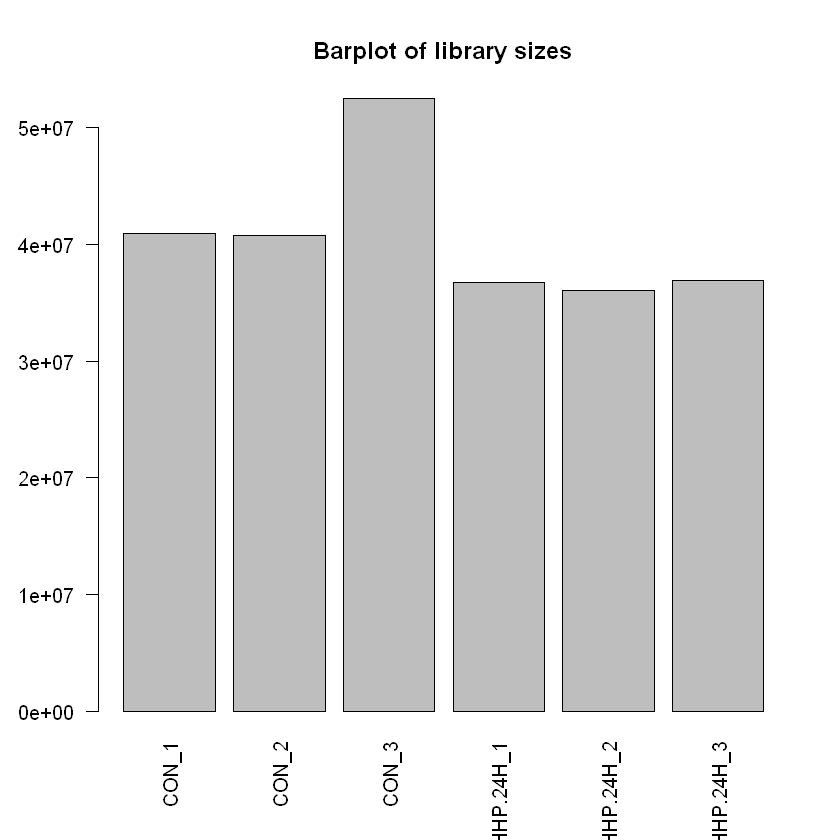

In [39]:
# Quality control Library size and distribution plots First, we can check how
# many reads we have for each sample in the y.
x$samples$lib.size
# The names argument tells the barplot to use the sample names on the x-axis
# The las argument rotates the axis names
barplot(x$samples$lib.size, names = colnames(x), las = 2)
# Add a title to the plot
title("Barplot of library sizes")

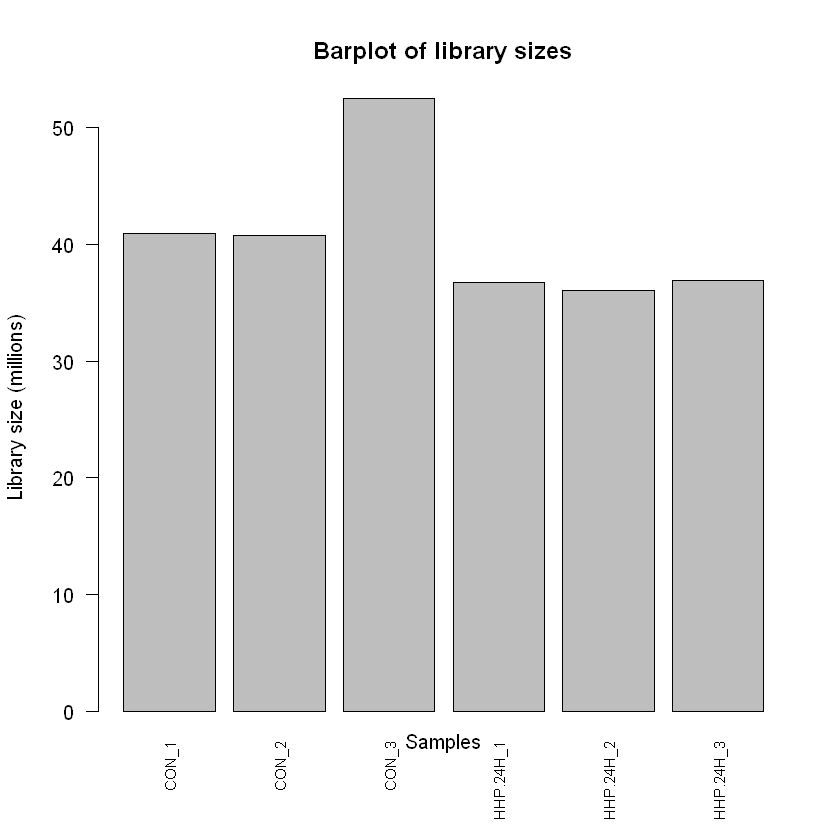

In [40]:
# we can also adjust the labelling if we want
barplot(x$samples$lib.size/1e+06, names = colnames(x), las = 2, ann = FALSE, cex.names = 0.75)
mtext(side = 1, text = "Samples", line = 0.5)
mtext(side = 2, text = "Library size (millions)", line = 3)
title("Barplot of library sizes")

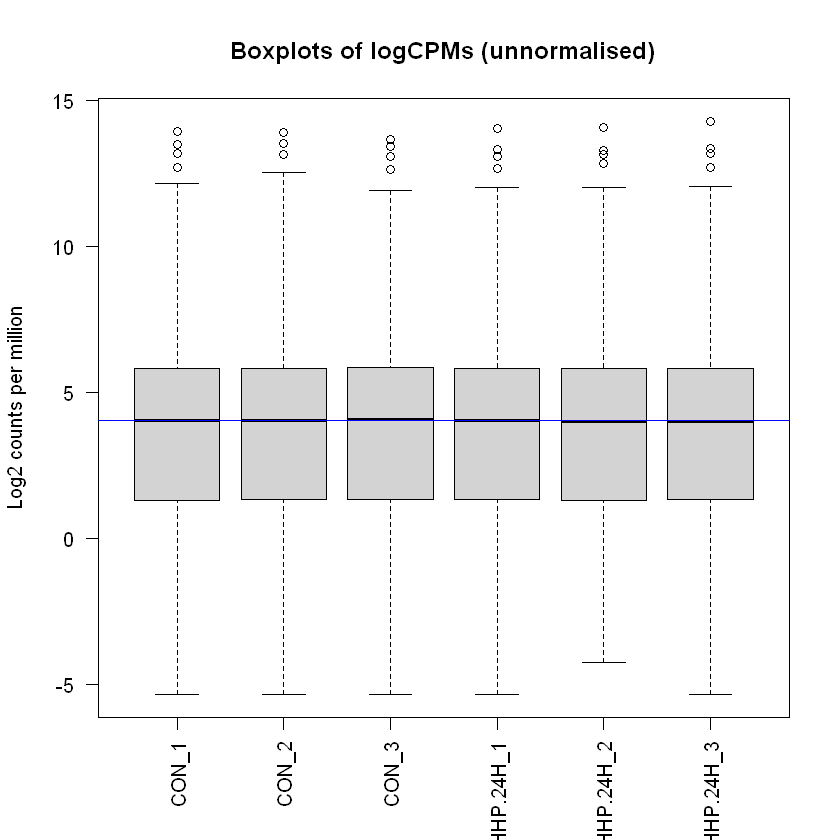

In [41]:
# Count data is not normally distributed, so if we want to examine the
# distributions of the raw counts we need to log the counts.  Get log2 counts
# per million
logcounts <- cpm(x, log = TRUE, prior.count = 1)
# Check distributions of samples using boxplots
boxplot(logcounts, xlab = "", ylab = "Log2 counts per million", las = 2)
# Let's add a blue horizontal line that corresponds to the median logCPM
abline(h = median(logcounts), col = "blue")
title("Boxplots of logCPMs (unnormalised)")

## Unsupervised clustering of samples
One of the most important exploratory plots to examine for gene expression analyses is the multi-dimensional scaling (MDS) plot, or similar. The plot shows similarities and dissimilarities between samples in an unsupervised manner so that one can have an idea of the extent to which differential expression can be detected before carrying out formal tests. Ideally, samples would cluster well within the primary condition of interest, and any sample straying far from its group could be identified and followed up for sources of error or extra variation. If present, technical replicates should lie very close to one another.

Such a plot can be made in limma using the plotMDS function. The first dimension represents the leading-fold-change that best separates samples and explains the largest proportion of variation in the data, with subsequent dimensions having a smaller effect and being orthogonal to the ones before it. When experimental design involves multiple factors, it is recommended that each factor is examined over several dimensions. If samples cluster by a given factor in any of these dimensions, it suggests that the factor contributes to expression differences and is worth including in the linear modelling. On the other hand, factors that show little or no effect may be left out of downstream analysis.


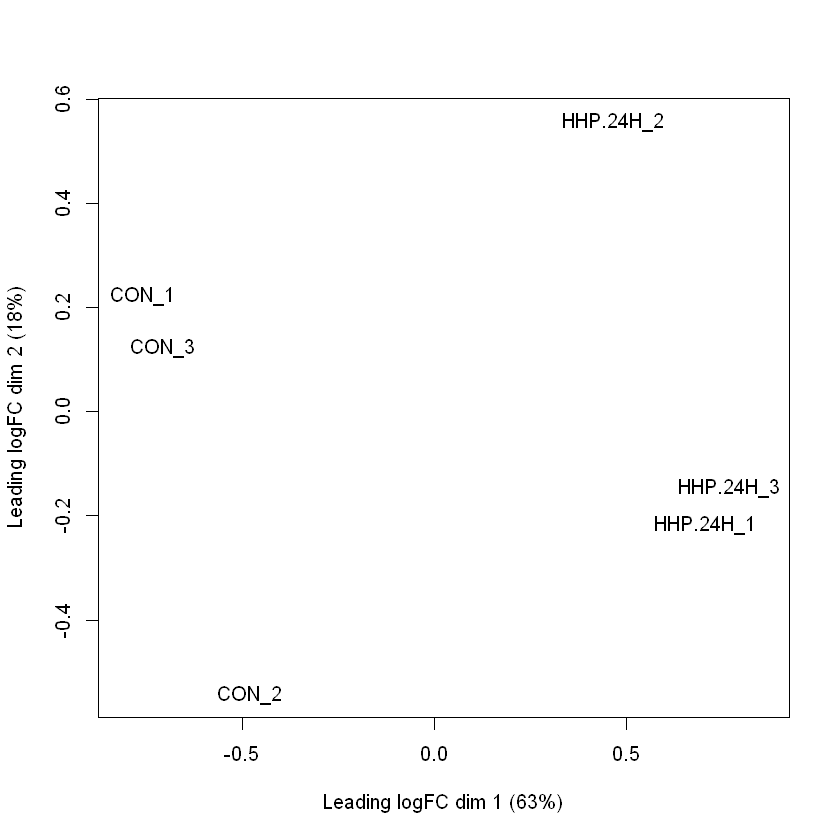

In [42]:
# An MDSplot is a visualisation of a principle components analysis, which
# determines the greatest sources of variation in the data.
plotMDS(x)

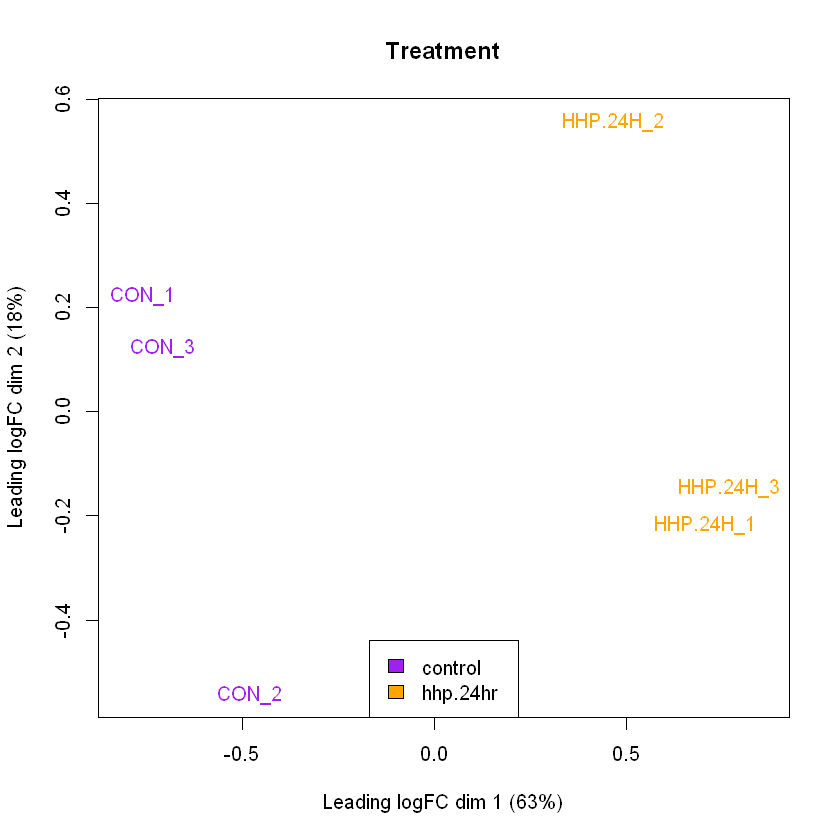

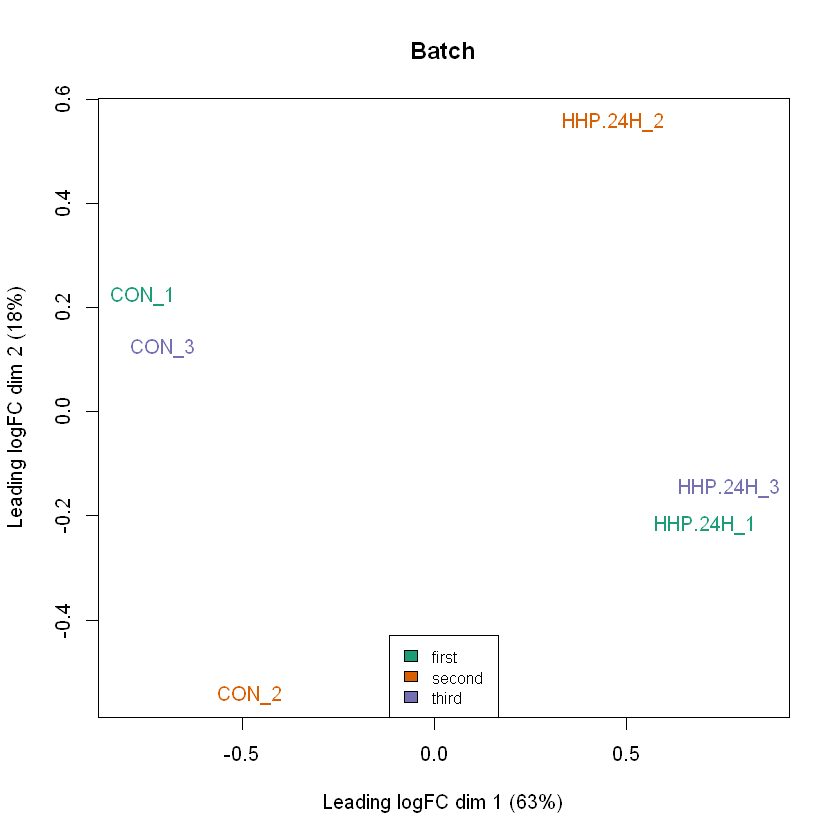

In [43]:
# Redo the MDSplot with corrected information
col.cell <- c("purple", "orange", "red", "blue")[sampleinfo$Treatment]
col.status <- c("#1B9E77", "#D95F02", "#7570B3")[sampleinfo$Batch]
char.celltype <- c(1, 4)[sampleinfo$Treatment]
plotMDS(x, col = col.cell)
legend("bottom", fill = c("purple", "orange", "red", "blue"), legend = levels(sampleinfo$Treatment))
title("Treatment")

p1 <- plotMDS(x, col = col.status)
legend("bottom", fill = c("#1B9E77", "#D95F02", "#7570B3"), legend = levels(sampleinfo$Batch),
    cex = 0.8)
title("Batch")

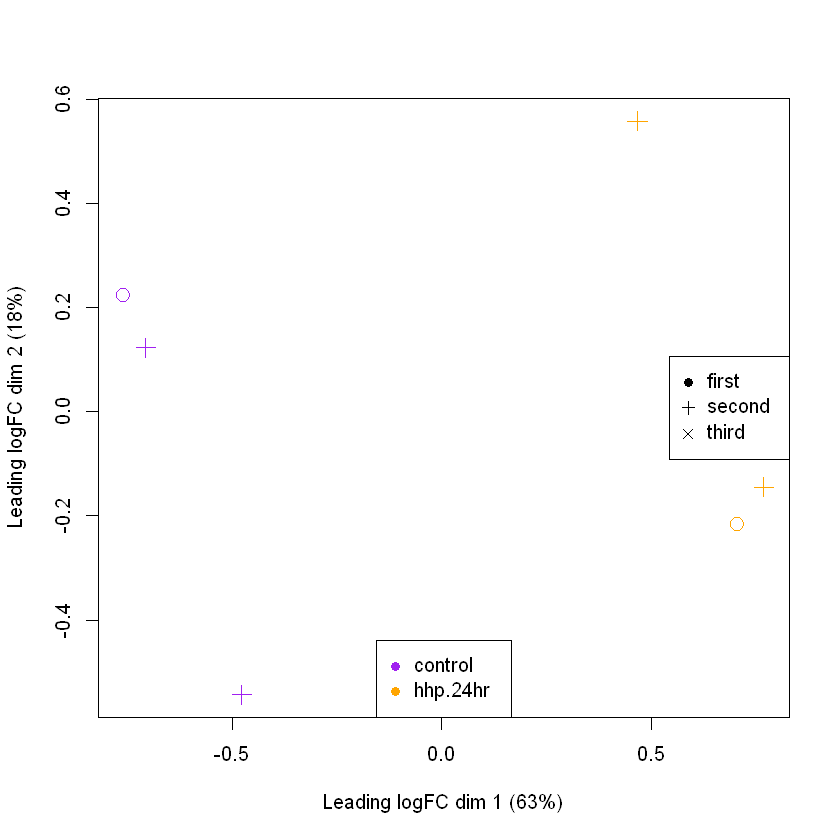

In [44]:
char.status <- c(1, 3, 3)[sampleinfo$Batch]
plotMDS(x, dim = c(1, 2), col = col.cell, pch = char.status, cex = 1.5)
legend("bottom", legend = levels(sampleinfo$Treatment), col = c("purple", "orange",
    "red", "blue"), pch = 16)
legend("right", legend = levels(sampleinfo$Batch), pch = c(16, 3, 4))

### Hierarchical clustering with heatmaps
A heatmap is created for the top 200 most variable genes and plot the heatmap using the heatmap.2 function from the gplots package. The heatmap correctly clusters samples by cell type and reorders the genes into blocks with similar expression patterns. From the heatmap, we observe that the expression of contol and drug samples are very similar for the top 200 most variable genes.

In [45]:
# Let's select data for the 500 most variable genes and plot the heatmap We
# estimate the variance for each row in the logcounts matrix
var_genes <- apply(logcounts, 1, var)
head(var_genes)
# Get the gene names for the top 500 most variable genes
select_var <- names(sort(var_genes, decreasing = TRUE))[1:200]
head(select_var)
# Subset logcounts matrix
highly_variable_lcpm <- logcounts[select_var, ]
dim(highly_variable_lcpm)
head(highly_variable_lcpm)

Xkr4     Gm38717       Sox17      Mrpl15      Lypla1       Tcea1 
0.043302940 0.026224703 0.017337888 0.005803512 0.005927129 0.010949938

[1] "A230052G05Rik" "Myod1"         "D730045A05Rik" "Slc28a3"      
[5] "Gm36317"       "1700034P13Rik"

[1] 200   6

,CON_1,CON_2,CON_3,HHP.24H_1,HHP.24H_2,HHP.24H_3
A230052G05Rik,-3.351942,-4.347383,-2.3510033,0.6548364,0.6588714,0.2815093
Myod1,-5.345377,-2.348889,-0.1206828,-5.3453769,-2.1917997,-0.9664309
D730045A05Rik,-5.345377,-2.179020,-4.5181123,-0.5624284,-1.4833775,-0.6279471
Slc28a3,-5.345377,-1.027263,-3.9956516,-5.3453769,-1.0103585,-3.6669913
Gm36317,-5.345377,-3.763090,-5.3453769,-1.3030820,-1.5999165,-1.3093245
1700034P13Rik,-5.345377,-3.348387,-3.0609843,-0.5624284,-0.7866558,-0.8920825


Warning message in heatmap.2(highly_variable_lcpm, scale = "row", col = rev(morecols(100)), :
"Discrepancy: Colv is FALSE, while dendrogram is `both'. Omitting column dendogram."


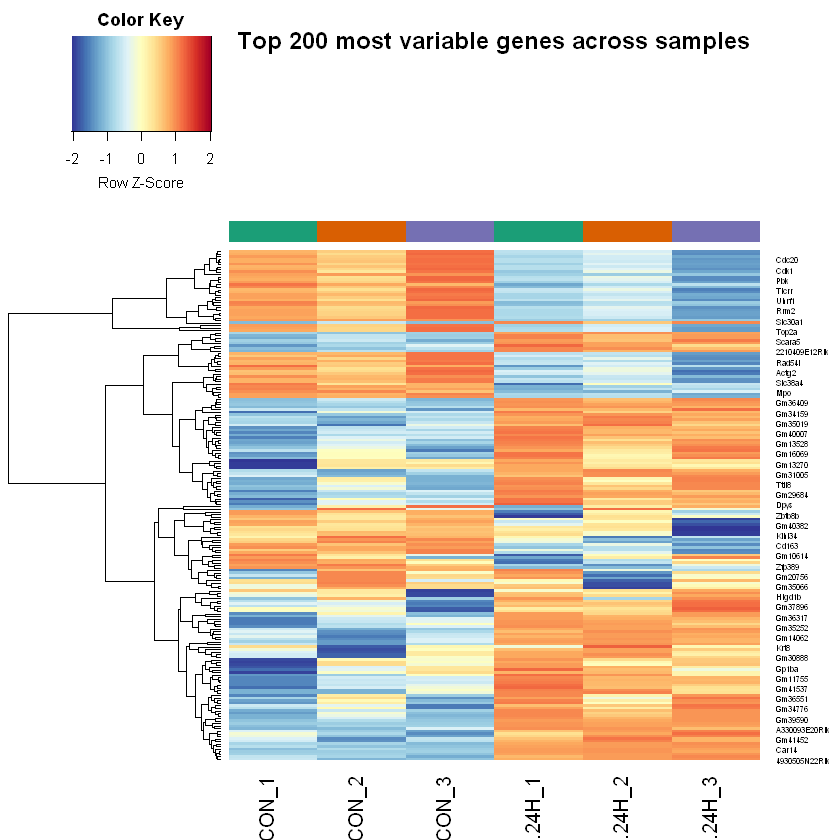

In [46]:
## Get some nicer colours
mypalette <- brewer.pal(11, "RdYlBu")
morecols <- colorRampPalette(mypalette)
# Set up colour vector for celltype variable
col.status <- c("#1B9E77", "#D95F02", "#7570B3")[sampleinfo$Batch]
# Plot the heatmap
heatmap.2(highly_variable_lcpm, scale = "row", col = rev(morecols(100)), density.info='none', Colv = F, trace = "none",
    main = "Top 200 most variable genes across samples", ColSideColors = col.status)

### Normalisation for composition bias

,files,group,lib.size,norm.factors
,<chr>,<fct>,<dbl>,<dbl>
CON_1,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_1_counts.txt,control,40903070,0.9880901
CON_2,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_2_counts.txt,control,40768747,1.0124112
CON_3,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_3_counts.txt,control,52504852,1.0007507
HHP.24H_1,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_1_counts.txt,hhp.24hr,36777977,1.0111621
HHP.24H_2,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_2_counts.txt,hhp.24hr,36030235,0.9940135
HHP.24H_3,C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_3_counts.txt,hhp.24hr,36947812,0.9938195


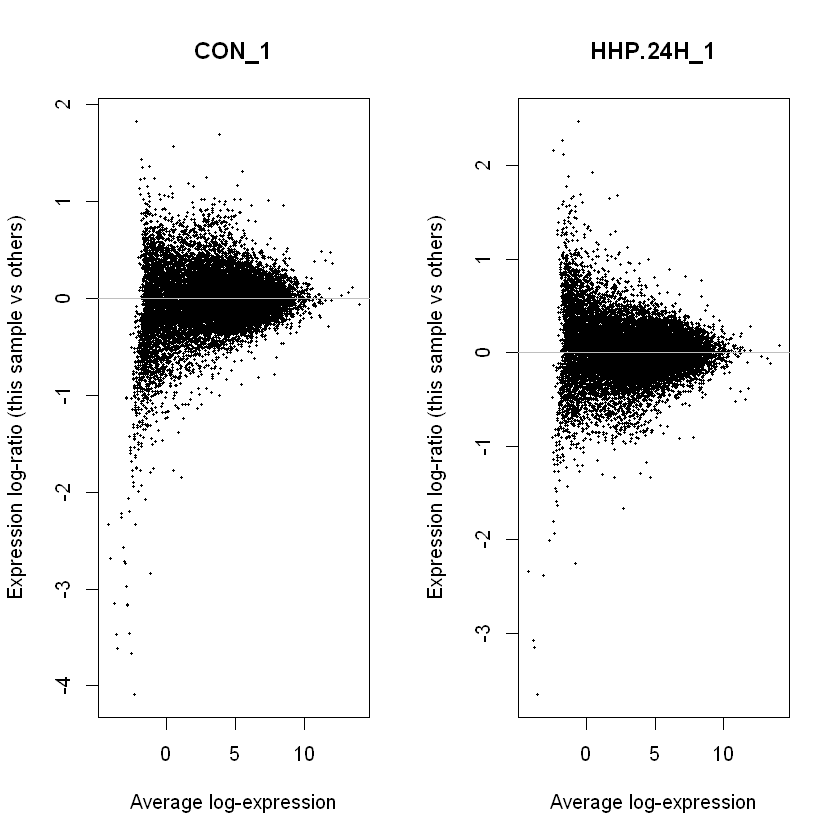

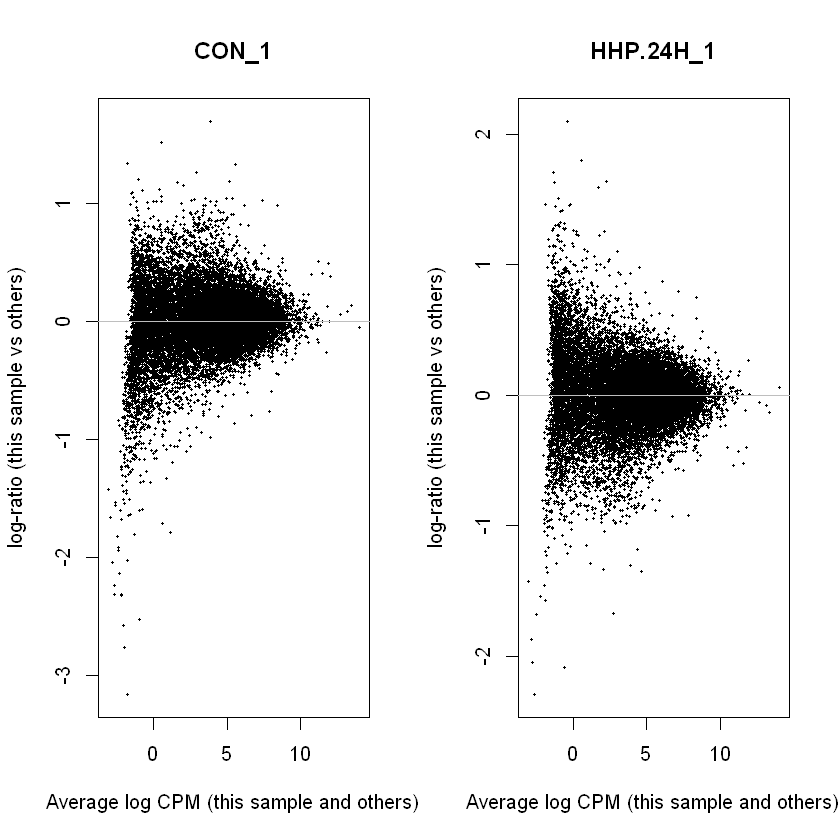

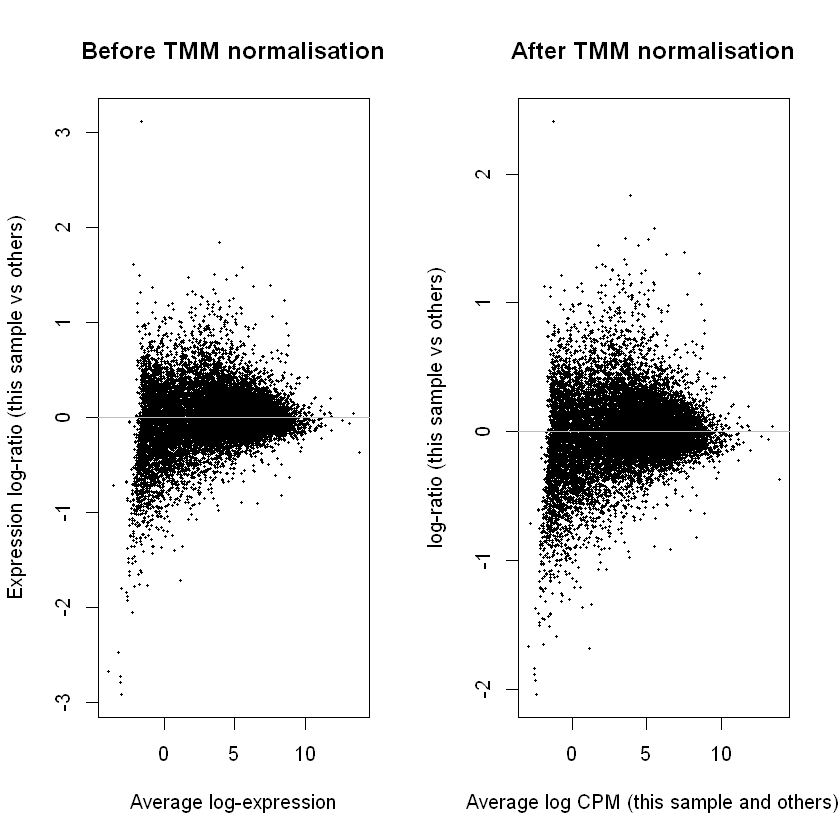

In [47]:
# The calcNormFactors function calculates the normalization factors between
# libraries.  TMM normalisation (and most scaling normalisation methods) scale
# relative to one sample.  Apply normalisation to DGEList object
x <- calcNormFactors(x)
x$samples
# The last two samples have much smaller normalisation factors, and MCL1.LA and
# MCL1.LB have the largest.  If we plot mean difference plots using the plotMD
# function for these samples, we should be able to see the composition bias
# problem.
par(mfrow = c(1, 2))
plotMD(logcounts, column = 1)
abline(h = 0, col = "grey")
plotMD(logcounts, column = 4)
abline(h = 0, col = "grey")
# if we redo these plots using y, we should see the composition bias problem
# has been solved.
par(mfrow = c(1, 2))
plotMD(x, column = 1)
abline(h = 0, col = "grey")
plotMD(x, column = 4)
abline(h = 0, col = "grey")
# Plot the biased and unbiased MD plots side by side for the same sample to see
# the before and after TMM normalisation effect.
par(mfrow = c(1, 2))
plotMD(logcounts, column = 3, main = "Before TMM normalisation")
abline(h = 0, col = "grey")
plotMD(x, column = 3, main = "After TMM normalisation")
abline(h = 0, col = "grey")

In [48]:
x[select_var, ]

An object of class "DGEList"
$samples
                                                                                                                    files
CON_1     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_1_counts.txt
CON_2     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_2_counts.txt
CON_3     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_3_counts.txt
HHP.24H_1     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_1_counts.txt
HHP.24H_2     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_2_counts.txt
HHP.24H_3     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_3_counts.txt
             group lib.size norm.factors
CON_1      control 40903070    0.9880901
CON_2      control 40768747    1.0124112
CON_3      control 52504852    1.0007507
HHP.24H_1 hhp.24hr 36777977    1.0111621
HHP.24H_2 hhp.24hr 36030235    0.9940135
HHP.24H_3 hhp.24hr 36947812    0.9938195

$counts
               Samples
Tags            CON_1 CON_2 CON_3 HHP.24H_1 HHP.24H_2 HHP.24H_3
  A230052G05Rik     3     1     9        57        56        44
  Myod1             0     7    47         0         7        18
  D730045A05Rik     0     8     1        24        12        23
  Slc28a3           0    19     2         0        17         2
  Gm36317           0     2     0        14        11        14
195 more rows ...

$genes
             SYMBOL  ENTREZID
31273 A230052G05Rik    442796
28840         Myod1     17927
15515 D730045A05Rik     77855
8428        Slc28a3    114304
23286       Gm36317 102640189
                                                                        GENENAME
31273                                                 RIKEN cDNA A230052G05 gene
28840                                                 myogenic differentiation 1
15515                                                 RIKEN cDNA D730045A05 gene
8428  solute carrier family 28 (sodium-coupled nucleoside transporter), member 3
23286                                                      predicted gene, 36317
195 more rows ...

In [49]:
saveRDS(x, "./x_with_correction.rds")
# saveRDS(x, './x_without_correction.rds')

## Differential expression with limma-voom
Linear modelling in limma is carried out using the lmFit and contrasts.fit functions originally written for application to microarrays. The functions can be used for both microarray and RNA-seq data and fit a separate model to the expression values for each gene. Next, empirical Bayes moderation is carried out by borrowing information across all the genes to obtain more precise estimates of gene-wise variability. The model’s residual variances are plotted against average expression values in the next figure. It can be seen from this plot that the variance is no longer dependent on the mean expression level.


In [ ]:
x <- readRDS("./output/for_publication/x_with_correction.rds")
summary(x)

                   Length Class      Mode     
samples                 4 data.frame list     
counts             153693 -none-     numeric  
genes                   3 data.frame list     
design                 45 -none-     numeric  
common.dispersion       1 -none-     numeric  
trended.dispersion  17077 -none-     numeric  
tagwise.dispersion  17077 -none-     numeric  
AveLogCPM           17077 -none-     numeric  
trend.method            1 -none-     character
prior.df            17077 -none-     numeric  
prior.n             17077 -none-     numeric  
span                    1 -none-     numeric  

In [50]:
# Create the design matrix Look at group variable again
treatment <- sampleinfo$Treatment
# Take a look
treatment
# Convert to factor
treatment <- factor(treatment)
# Specify a design matrix without an intercept term
design <- model.matrix(~0 + treatment)
design
# Make the column names of the design matrix a bit nicer
colnames(design) <- levels(treatment)
design

[1] control  control  control  hhp.24hr hhp.24hr hhp.24hr
Levels: control hhp.24hr

,treatmentcontrol,treatmenthhp.24hr
1,1,0
2,1,0
3,1,0
4,0,1
5,0,1
6,0,1


,control,hhp.24hr
1,1,0
2,1,0
3,1,0
4,0,1
5,0,1
6,0,1


An object of class "EList"
$genes
    SYMBOL ENTREZID                                  GENENAME
1     Xkr4   497097         X-linked Kx blood group related 4
3  Gm38717     <NA>                                      <NA>
5    Sox17    20671     SRY (sex determining region Y)-box 17
10  Mrpl15    27395       mitochondrial ribosomal protein L15
11  Lypla1    18777                       lysophospholipase 1
13   Tcea1    21399 transcription elongation factor A (SII) 1

$targets
                                                                                                                    files
CON_1     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_1_counts.txt
CON_2     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_2_counts.txt
CON_3     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/Control_3_counts.txt
HHP.24H_1     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_1_counts.txt
HHP.24H_2     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_2_counts.txt
HHP.24H_3     C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/GitHub/RNAseq/input/HHP_2h_24h_WT/24h_3_counts.txt
             group lib.size norm.factors
CON_1      control 40415920    0.9880901
CON_2      control 41274738    1.0124112
CON_3      control 52544269    1.0007507
HHP.24H_1 hhp.24hr 37188495    1.0111621
HHP.24H_2 hhp.24hr 35814539    0.9940135
HHP.24H_3 hhp.24hr 36719458    0.9938195

$E
         Samples
Tags          CON_1      CON_2      CON_3  HHP.24H_1 HHP.24H_2 HHP.24H_3
  Xkr4     5.684475  5.6582985  5.5880338  5.2328800  5.251683  5.332421
  Gm38717 -0.782263 -0.7524773 -0.6493723 -0.3838945 -0.434553 -0.583763
  Sox17    2.244349  2.4433845  2.5061256  2.5743784  2.388273  2.329004
  Mrpl15   4.618071  4.6250431  4.7155136  4.5913753  4.579836  4.495885
  Lypla1   5.407562  5.3509175  5.3802651  5.2141907  5.264315  5.246024
  Tcea1    6.476729  6.3824728  6.4785258  6.2398266  6.326622  6.241098

$weights
          [,1]      [,2]      [,3]      [,4]      [,5]      [,6]
[1,] 287.36416 289.71359 315.68111 247.39937 242.92796 245.88038
[2,]  16.53484  16.76849  19.75457  17.65097  17.20995  17.50071
[3,]  78.51406  79.62666  93.43411  75.33314  73.41975  74.68113
[4,] 207.03513 209.44369 237.54682 190.55273 186.58473 189.20319
[5,] 266.20437 268.68942 296.30691 244.84964 240.43563 243.35017
[6,] 344.29706 346.17882 366.36087 324.68526 320.96998 323.45098

$design
  control hhp.24hr
1       1        0
2       1        0
3       1        0
4       0        1
5       0        1
6       0        1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$treatment
[1] "contr.treatment"

[1] "genes"   "targets" "E"       "weights" "design"

[1] 16715     6

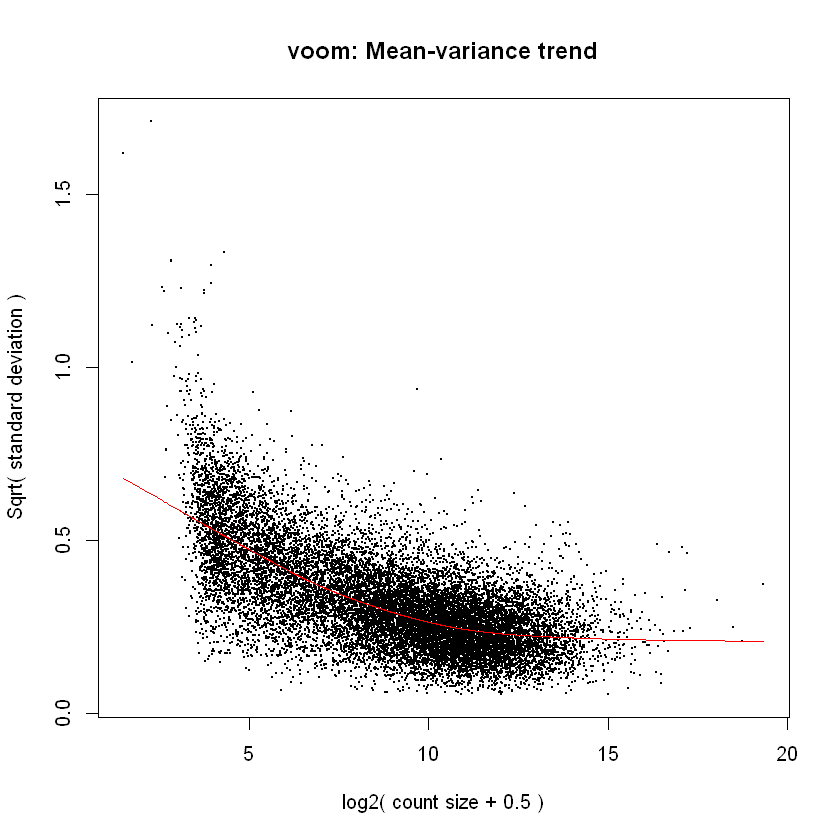

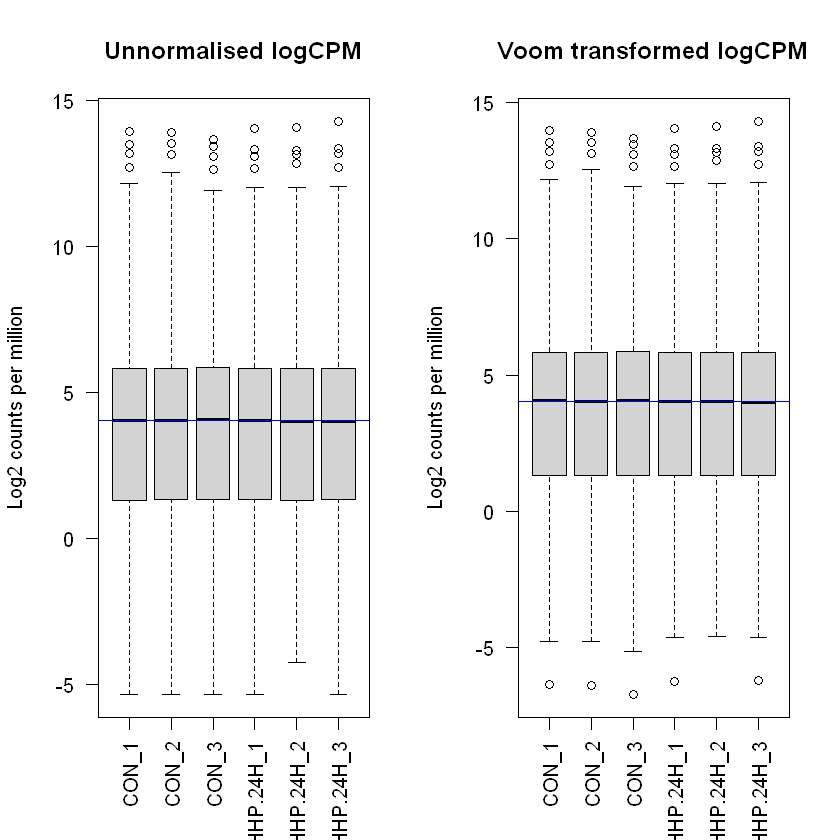

In [51]:
# Voom transform the data
v <- voom(x, design, plot = TRUE)
head(v)
# What is contained in this object?
names(v)
dim(v$weights)
# We can repeat the box plots for the normalised data to compare to before
# normalisation.  The expression values in v$E are already log2 values so we
# don't need to log-transform.
par(mfrow = c(1, 2))
boxplot(logcounts, xlab = "", ylab = "Log2 counts per million", las = 2, main = "Unnormalised logCPM")
## Let's add a blue horizontal line that corresponds to the median logCPM
abline(h = median(logcounts), col = "blue")
boxplot(v$E, xlab = "", ylab = "Log2 counts per million", las = 2, main = "Voom transformed logCPM")
## Let's add a blue horizontal line that corresponds to the median logCPM
abline(h = median(v$E), col = "blue")

## Testing for differential expression, contro vs HHP.24h

In [52]:
# Now that we have the voom transformed data we can use limma to test for
# differential expression.  Fit the linear model
fit <- lmFit(v)
names(fit)
# The comparison of interest can be specified using the makeContrasts function.
cont.matrix <- makeContrasts(convs24h = hhp.24hr - control, levels = design)
cont.matrix
# Now we can apply the contrasts matrix to the fit object to get the statistics
# and estimated parameters of our comparison that we are interested in.  Now we
# can apply the contrasts matrix to the fit object to get the statistics and
# estimated parameters of our comparison that we are interested in.
fit.cont.B <- contrasts.fit(fit, cont.matrix)
# The final step is to call the eBayes function, which performs empirical Bayes
# shrinkage on the variances, and estimates moderated t-statistics and the
# associated p-values.
fit.cont.B <- eBayes(fit.cont.B)
# Check the dimensions of the fit object
dim(fit.cont.B)
# We can use the limma decideTests function to generate a quick summary of DE
# genes for the contrasts.
summa.fit.B <- decideTests(fit.cont.B, adjust.method = "BH", lfc = 0.5)
summary(summa.fit.B)

[1] "coefficients"     "stdev.unscaled"   "sigma"            "df.residual"     
 [5] "cov.coefficients" "pivot"            "rank"             "genes"           
 [9] "Amean"            "method"           "design"

,convs24h
control,-1
hhp.24hr,1


[1] 16715     1

       convs24h
Down       1019
NotSig    14673
Up         1023

In [53]:
head(fit.cont.B)

,convs24h
Xkr4,-0.36954913
Gm38717,0.25602519
Sox17,0.02664111
Mrpl15,-0.10002359
Lypla1,-0.13815777
Tcea1,-0.17747936
,convs24h
Xkr4,0.04978389
Gm38717,0.19479551
Sox17,0.09192690


In [55]:
seq_tab <- topTable(fit.cont.B, adjust = "BH", n = "inf")
head(seq_tab)
dim(seq_tab)

,SYMBOL,ENTREZID,GENENAME,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mt2,Mt2,17750,metallothionein 2,-2.9667881,3.270949,-44.71491,2.542220e-09,4.249321e-05,10.447207
Slc39a10,Slc39a10,227059,"solute carrier family 39 (zinc transporter), member 10",1.3895970,6.915651,31.86317,2.267839e-08,9.476731e-05,10.312108
Slc30a1,Slc30a1,22782,"solute carrier family 30 (zinc transporter), member 1",-1.6030999,3.909567,-34.12957,1.455843e-08,8.111470e-05,10.152328
Tac1,Tac1,21333,tachykinin 1,1.0300185,6.560883,30.01384,3.334243e-08,1.114637e-04,9.938360
Pdrg1,Pdrg1,68559,p53 and DNA damage regulated 1,0.9789992,5.655328,29.13716,4.035889e-08,1.124331e-04,9.722825
Calr3,Calr3,73316,calreticulin 3,1.7956720,2.624883,34.73253,1.300266e-08,8.111470e-05,9.550633


[1] 16715     9

In [56]:
write.csv(seq_tab, "RNA-seqResults-Convs24h.csv")

In [57]:
saveRDS(seq_tab, "./seq_tab.rds")

### Plots after testing for DE
To summarise results for all genes visually, mean-difference plots, which display log-FCs from the linear model fit against the average log-CPM values can be generated using the plotMD function, with the differentially expressed genes highlighted.

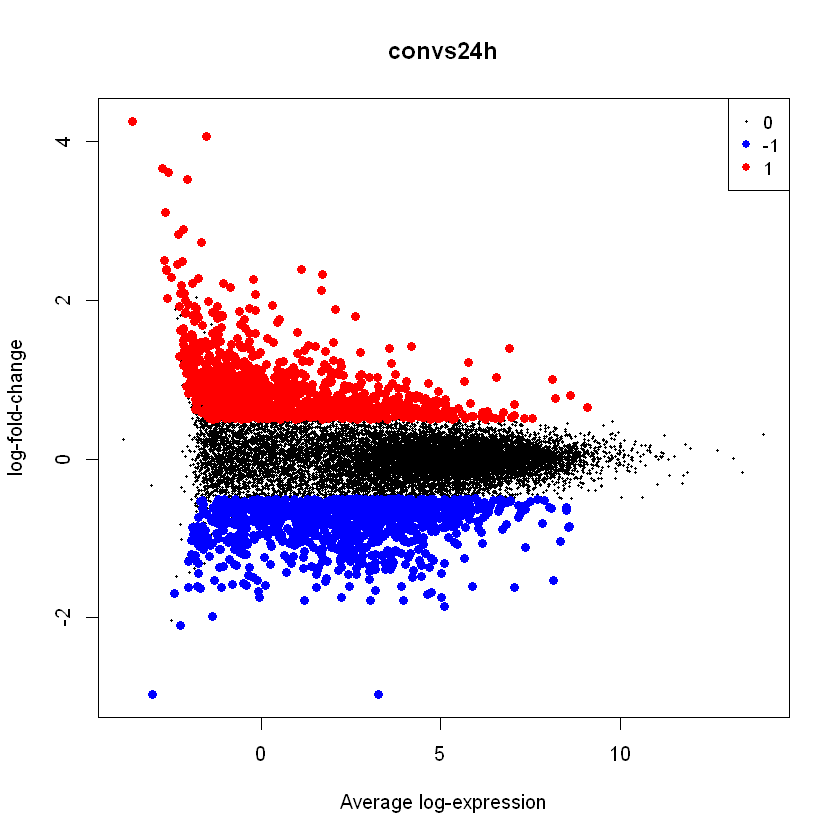

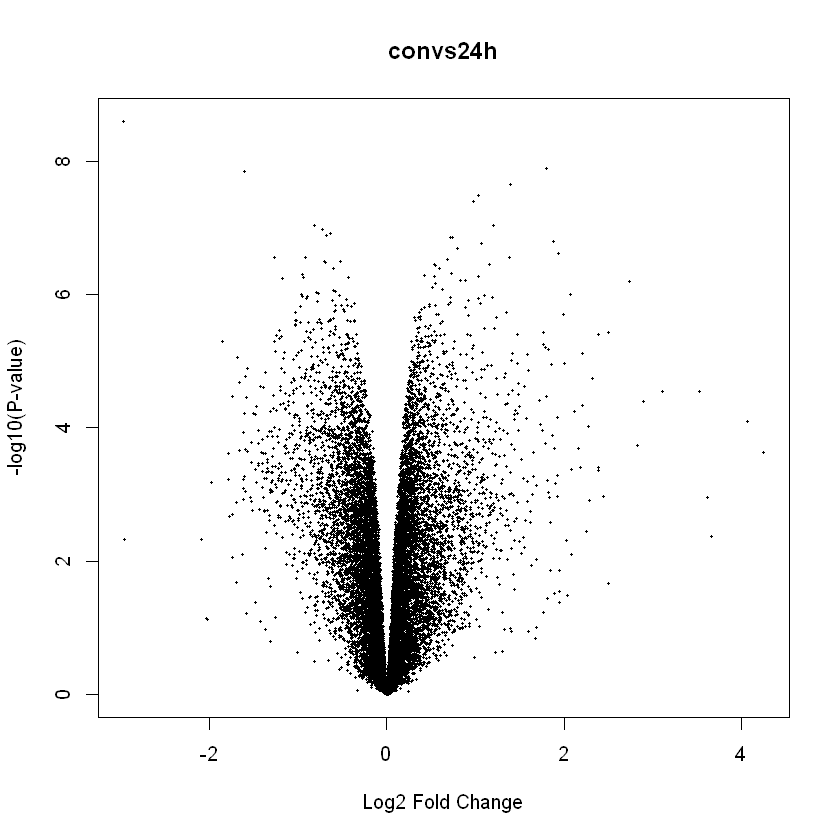

In [58]:
# We want to highlight the significant genes. We can get this from decideTests.
plotMD(fit.cont.B, coef = 1, status = summa.fit.B[, "convs24h"], values = c(-1, 1),
    hl.col = c("blue", "red"))
# For the volcano plot we have to specify how many of the top genes to
# highlight.  We can also specify that we want to plot the gene symbol for the
# highlighted genes.  let's highlight the top 100 most DE genes
volcanoplot(fit.cont.B, coef = 1,  names = fit.cont.B$genes$SYMBOL,
    main = "convs24h")
# ook at the MD plot and volcano plot for the second comparison, L.PregVsLac.
# Change the number of highlighted genes to 200 in the volcano plot.

### Examining the number of DE genes
For a quick look at differential expression levels, the number of significantly up- and down-regulated genes can be summarised in a table. Significance is defined using an adjusted p-value cutoff that is set at 5% by default. For the comparison between expression levels in basal and LP, 4,648 genes are found to be down-regulated in basal relative to LP and 4,863 genes are up-regulated in basal relative to LP – a total of 9,511 DE genes. A total of 9,598 DE genes are found between basal and ML (4,927 down- and 4,671 up-regulated genes), and a total of 5,652 DE genes are found between LP and ML (3,135 down- and 2,517 up-regulated). The larger numbers of DE genes observed for comparisons involving the basal population are consistent with our observations from the MDS plots.

In [59]:
summary(summa.fit.B)

       convs24h
Down       1019
NotSig    14673
Up         1023

### Testing relative to a threshold (TREAT)
In other words, you are not controlling the false discovery rate at 5% any  more. There is a function called treat in the limma package that performs this style of analysis correctly (McCarthy and Smyth 2009).  Let's decide that we are only interested in genes that have a absolute logFC of 1.  This corresponds to a fold change of 2, or 0.5 (i.e.  double or half).  We can perform a treat analysis which ranks our genes according to p-value AND logFC.  This is easy to do after our analysis, we just give the treat function the fit.cont object and specify our cut-off.


       convs24h
Down        455
NotSig    15881
Up          379

,SYMBOL,ENTREZID,GENENAME,logFC,AveExpr,t,P.Value,adj.P.Val
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mt2,Mt2,17750,metallothionein 2,-2.9667881,3.2709491,-40.19336,3.213648e-09,5.371613e-05
Calr3,Calr3,73316,calreticulin 3,1.7956720,2.6248831,28.92983,2.352637e-08,1.675800e-04
Slc30a1,Slc30a1,22782,"solute carrier family 30 (zinc transporter), member 1",-1.6030999,3.9095666,-27.74265,3.007718e-08,1.675800e-04
Slc39a10,Slc39a10,227059,"solute carrier family 39 (zinc transporter), member 10",1.3895970,6.9156506,24.98423,5.748201e-08,2.402029e-04
Tac1,Tac1,21333,tachykinin 1,1.0300185,6.5608828,21.27210,1.555075e-07,5.198617e-04
Pdrg1,Pdrg1,68559,p53 and DNA damage regulated 1,0.9789992,5.6553276,20.20850,2.150767e-07,5.991678e-04
Gm39663,Gm39663,105243956,"predicted gene, 39663",1.8814494,2.0653861,19.70893,2.797036e-07,6.310893e-04
Kcnn1,Kcnn1,84036,"potassium intermediate/small conductance calcium-activated channel, subfamily N, member 1",1.2059196,3.6281919,19.22472,3.020469e-07,6.310893e-04
Apob,Apob,238055,apolipoprotein B,1.9301616,0.3158911,18.59523,4.081239e-07,7.579768e-04


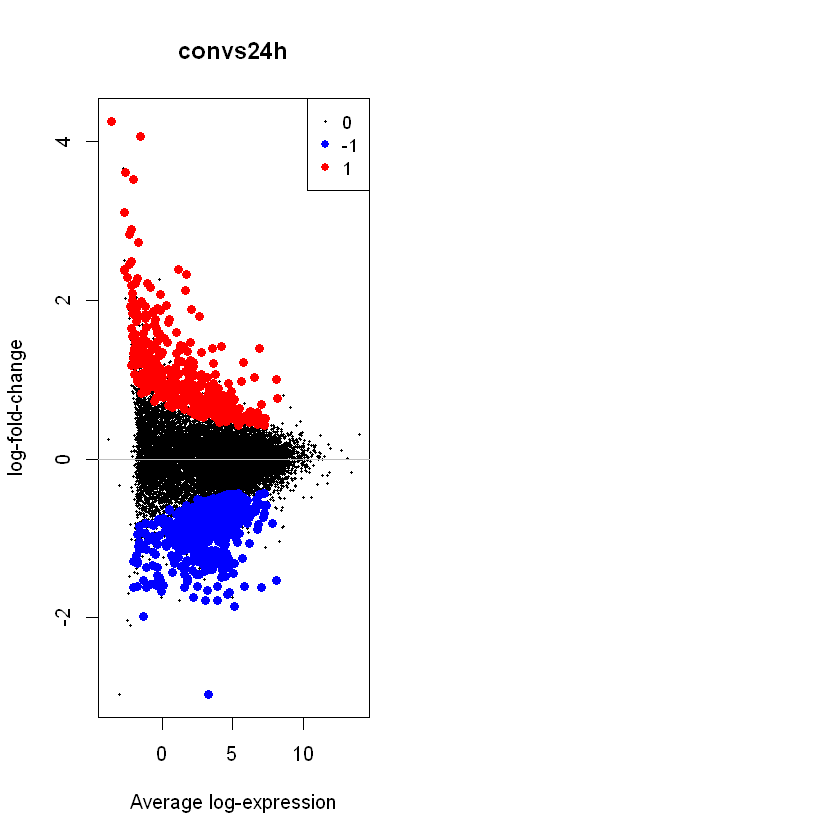

In [60]:
# In other words, you are not controlling the false discovery rate at 5% any
# more. There is a function called treat in the limma package that performs
# this style of analysis correctly (McCarthy and Smyth 2009).  Let's decide
# that we are only interested in genes that have a absolute logFC of 1.  This
# corresponds to a fold change of 2, or 0.5 (i.e.  double or half).  We can
# perform a treat analysis which ranks our genes according to p-value AND
# logFC.  This is easy to do after our analysis, we just give the treat
# function the fit.cont object and specify our cut-off.
fit.treat.B <- treat(fit.cont.B, lfc = 0.3)
res.treat.B <- decideTests(fit.treat.B)
summary(res.treat.B)

# Calculate the treat seperately
topTable(fit.treat.B, coef = 1, sort.by = "p")
# Notice that much fewer genes are highlighted in the MAplot
par(mfrow = c(1, 2))
plotMD(fit.treat.B, coef = 1, status = res.treat.B[, "convs24h"], values = c(-1,
    1), hl.col = c("blue", "red"))
abline(h = 0, col = "grey")

# An interactive version of the mean-difference plots is possible via the
# glMDPlot function in the Glimma package.
glMDPlot(fit.treat.B, coef = 1, counts = v$E, groups = treatment, status = res.treat.B,
    side.main = "ENTREZID", main = "convs24h", folder = "md")

In [61]:
topTable(fit.treat.B, coef = 1, sort.by = "p")

,SYMBOL,ENTREZID,GENENAME,logFC,AveExpr,t,P.Value,adj.P.Val
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mt2,Mt2,17750,metallothionein 2,-2.9667881,3.2709491,-40.19336,3.213648e-09,5.371613e-05
Calr3,Calr3,73316,calreticulin 3,1.7956720,2.6248831,28.92983,2.352637e-08,1.675800e-04
Slc30a1,Slc30a1,22782,"solute carrier family 30 (zinc transporter), member 1",-1.6030999,3.9095666,-27.74265,3.007718e-08,1.675800e-04
Slc39a10,Slc39a10,227059,"solute carrier family 39 (zinc transporter), member 10",1.3895970,6.9156506,24.98423,5.748201e-08,2.402029e-04
Tac1,Tac1,21333,tachykinin 1,1.0300185,6.5608828,21.27210,1.555075e-07,5.198617e-04
Pdrg1,Pdrg1,68559,p53 and DNA damage regulated 1,0.9789992,5.6553276,20.20850,2.150767e-07,5.991678e-04
Gm39663,Gm39663,105243956,"predicted gene, 39663",1.8814494,2.0653861,19.70893,2.797036e-07,6.310893e-04
Kcnn1,Kcnn1,84036,"potassium intermediate/small conductance calcium-activated channel, subfamily N, member 1",1.2059196,3.6281919,19.22472,3.020469e-07,6.310893e-04
Apob,Apob,238055,apolipoprotein B,1.9301616,0.3158911,18.59523,4.081239e-07,7.579768e-04


## Select gene for GO analysis
Further analyses are required to interpret the differential expression results in a biological context. One common downstream procedure is a gene ontology (GO) enrichment analysis.

The analysis of significantly enriched GO (Gene Onthology) terms over-represented among DEG lists was performed with the ClusterProfiler package in R later. We need select the DEG for further GO analysis.

In [62]:
select_genes <- summa.fit.B == 1
sum(select_genes)
head(select_genes)

[1] 1023

,convs24h
Xkr4,FALSE
Gm38717,FALSE
Sox17,FALSE
Mrpl15,FALSE
Lypla1,FALSE
Tcea1,FALSE


In [63]:
head(fit.cont.B[select_genes, ])

,convs24h
St18,0.5189651
Gm26901,1.0662374
1700034P13Rik,3.6115316
Gm39590,2.8905855
Tcf24,0.5295191
Gm31523,0.6554146
,convs24h
St18,0.19904535
Gm26901,0.09860526
1700034P13Rik,0.30558837


In [64]:
forGO <- cbind(fit.cont.B[select_genes, ]$coefficients, fit.cont.B[select_genes,
    ]$p.value)
# choose the gene for further GO analysis differential genes after ComBat-seq
# correction
dim(forGO)

[1] 1023    2

In [65]:
write.csv(forGO, "forGO_up.csv")

In [ ]:
summa.fit.B <- summa.fit.B[select_genes, ]

In [ ]:
saveRDS(summa.fit.B, "./summa.fit.B_neuron.rds")

## Differential expression after batch effect correction with edgeR
We also can use the mixed model from edgeR for batch-effect correction.
In this case, additive model formulas are used is when correcting for batch effects in an experiment. The situation here is analogous to blocking, the only difference being that the batch effects were probably unintended rather than a deliberate aspect of the experimental design. The analysis is the same as for blocking. The treatments can be adjusted for differences between the batches by using an additive model formula of the form.

In [ ]:
x <- readRDS("./x_without_correction.rds")
summary(x)

                   Length Class      Mode     
samples                 4 data.frame list     
counts             154611 -none-     numeric  
genes                   3 data.frame list     
design                 45 -none-     numeric  
common.dispersion       1 -none-     numeric  
trended.dispersion  17179 -none-     numeric  
tagwise.dispersion  17179 -none-     numeric  
AveLogCPM           17179 -none-     numeric  
trend.method            1 -none-     character
prior.df            17179 -none-     numeric  
prior.n             17179 -none-     numeric  
span                    1 -none-     numeric  

In [65]:
# Create the design matrix Look at group variable again
treatment <- sampleinfo$Treatment
treatment <- factor(treatment)
batch <- sampleinfo$Batch
batch <- factor(batch)
treatment
batch

[1] control  control  control  hhp.24hr hhp.24hr hhp.24hr
Levels: control hhp.24hr

[1] first  second third  first  second third 
Levels: first second third

In [66]:
# Specify a design matrix without an intercept term Make the column names of
# the design matrix a bit nicer
design <- model.matrix(~batch + treatment)
rownames(design) <- colnames(x)
design

,(Intercept),batchsecond,batchthird,treatmenthhp.24hr
CON_1,1,0,0,0
CON_2,1,1,0,0
CON_3,1,0,1,0
HHP.24H_1,1,0,0,1
HHP.24H_2,1,1,0,1
HHP.24H_3,1,0,1,1


[1] 0.007728491

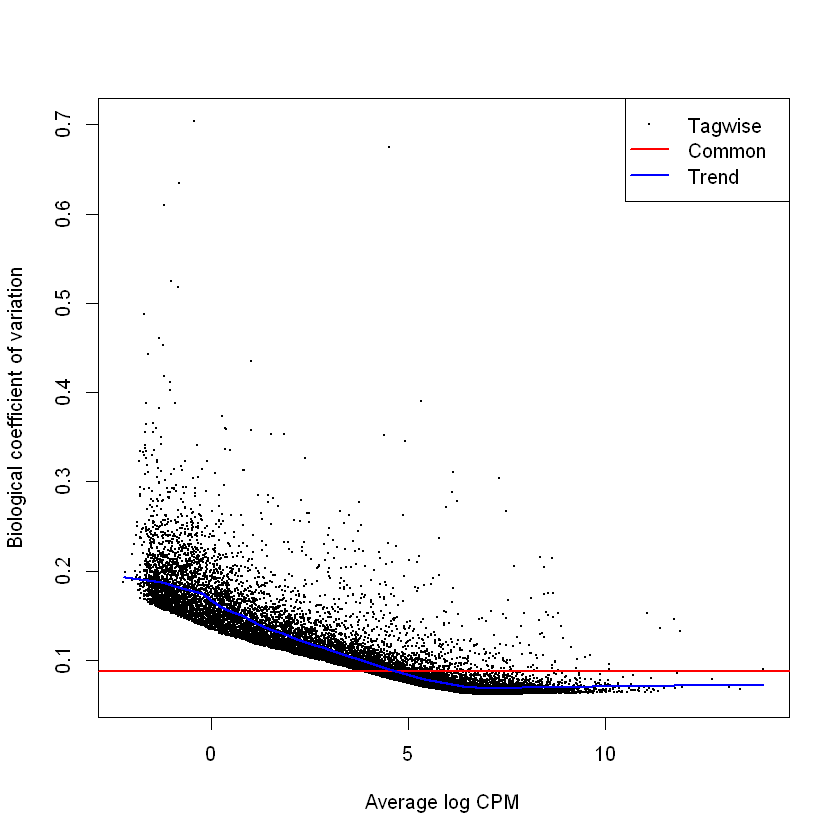

In [67]:
x <- estimateDisp(x, design, robust = TRUE)
x$common.dispersion
plotBCV(x)

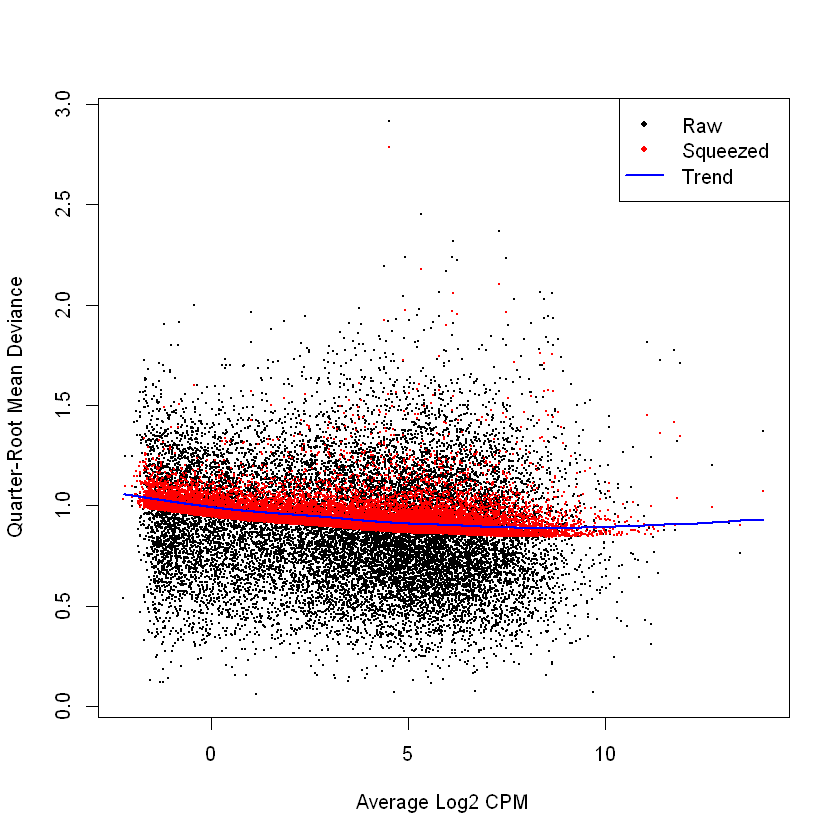

In [68]:
fit <- glmQLFit(x, design, robust = TRUE)
plotQLDisp(fit)

In [69]:
qlf <- glmQLFTest(fit, coef = 1:4)
topTags(qlf)

,SYMBOL,ENTREZID,GENENAME,logFC..Intercept.,logFC.batchsecond,logFC.batchthird,logFC.treatmenthhp.24hr,logCPM,F,PValue,FDR
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Raly,Raly,19383,hnRNP-associated with lethal yellow,-12.93894,-0.003127505,0.002764481,-0.14247316,6.923757,9822.463,2.080078e-19,5.053418e-18
Map2k7,Map2k7,26400,mitogen-activated protein kinase kinase 7,-13.05136,-0.003149910,0.002571178,0.07875056,6.920385,9810.318,2.094237e-19,5.053418e-18
Map4k3,Map4k3,225028,mitogen-activated protein kinase kinase kinase kinase 3,-12.94726,-0.002938310,0.002808139,-0.11660707,6.927832,9808.243,2.096667e-19,5.053418e-18
Tmem178b,Tmem178b,434008,transmembrane protein 178B,-13.11048,-0.003300263,0.002427534,0.03309047,6.837981,9783.140,2.126335e-19,5.053418e-18
Gns,Gns,75612,glucosamine (N-acetyl)-6-sulfatase,-12.96706,-0.003101103,0.002603986,0.06097474,6.995606,9782.466,2.127138e-19,5.053418e-18
Gnai3,Gnai3,14679,"guanine nucleotide binding protein (G protein), alpha inhibiting 3",-13.03217,-0.002952102,0.002696365,0.07100470,6.935709,9778.740,2.131586e-19,5.053418e-18
Mef2d,Mef2d,17261,myocyte enhancer factor 2D,-12.97299,-0.003199635,0.002643037,0.07909633,6.998921,9778.329,2.132077e-19,5.053418e-18
Uhmk1,Uhmk1,16589,U2AF homology motif (UHM) kinase 1,-13.23873,-0.003288837,0.002626863,0.22345692,6.808968,9771.803,2.139896e-19,5.053418e-18
Shc2,Shc2,216148,SHC (Src homology 2 domain containing) transforming protein 2,-13.18358,-0.003029055,0.002714800,0.09500568,6.796637,9766.511,2.146262e-19,5.053418e-18


In [70]:
FDR <- p.adjust(qlf$table$PValue, method = "BH")
sum(FDR < 0.05)

[1] 16715

In [71]:
qlf <- glmQLFTest(fit, coef = 4)
topTags(qlf)

,SYMBOL,ENTREZID,GENENAME,logFC,logCPM,F,PValue,FDR
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mt2,Mt2,17750,metallothionein 2,-2.9679424,3.950210,692.2000,2.915576e-11,4.873385e-07
Slc39a10,Slc39a10,227059,"solute carrier family 39 (zinc transporter), member 10",1.3884489,7.076284,427.6557,3.896331e-10,3.256359e-06
Slc30a1,Slc30a1,22782,"solute carrier family 30 (zinc transporter), member 1",-1.6030021,4.135600,267.5251,4.735552e-09,2.603796e-05
Tac1,Tac1,21333,tachykinin 1,1.0308145,6.650543,253.9752,6.231041e-09,2.603796e-05
Calr3,Calr3,73316,calreticulin 3,1.7976288,2.871940,200.1417,2.175761e-08,7.273570e-05
Pdrg1,Pdrg1,68559,p53 and DNA damage regulated 1,0.9789700,5.735567,188.6776,2.959239e-08,8.109815e-05
Sprn,Sprn,212518,shadow of prion protein,-1.2747026,4.562231,183.7479,3.396273e-08,8.109815e-05
Gm39663,Gm39663,105243956,"predicted gene, 39663",1.8849768,2.334014,161.5318,6.621713e-08,1.372711e-04
Prrg2,Prrg2,65116,proline-rich Gla (G-carboxyglutamic acid) polypeptide 2,1.3898088,3.722686,158.1263,7.391203e-08,1.372711e-04


In [72]:
summa.fit.L <- decideTests(qlf, lfc = 0.5)
summary(summa.fit.L)

       treatmenthhp.24hr
Down                 756
NotSig             15418
Up                   541

In [73]:
top <- rownames(topTags(qlf))
cpm(x)[top, ]

,CON_1,CON_2,CON_3,HHP.24H_1,HHP.24H_2,HHP.24H_3
Mt2,25.831405,27.111014,27.976410,3.630155,3.406438,3.295256
Slc39a10,76.207594,76.439008,71.311298,191.457063,189.950792,204.850519
Slc30a1,26.548944,25.221238,26.758389,8.497252,8.906997,8.442390
Tac1,66.458960,63.913186,67.790457,134.208174,138.854224,131.864692
Calr3,3.216554,3.391905,3.292462,11.697166,11.196570,11.547011
Pdrg1,35.109927,36.777944,35.798386,72.253529,68.743033,71.270116
Sprn,35.208898,32.126188,32.315608,12.880328,14.128341,14.161429
Gm39663,2.301073,1.986687,2.226694,7.690551,8.516095,7.897720
Prrg2,6.828992,7.656015,7.479408,20.355758,18.344505,18.900061
Stat1,90.632603,86.542040,87.944891,48.993647,51.068646,50.654343


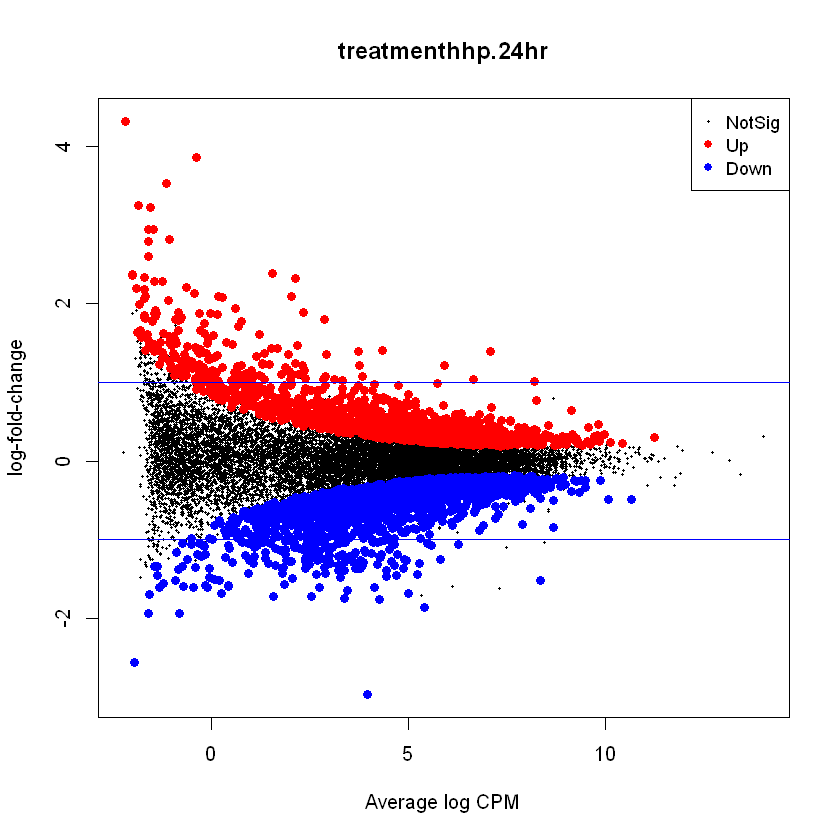

In [74]:
plotMD(qlf)
abline(h = c(-1, 1), col = "blue")

## Examining the number of DE genes identified after batch effect correction.
We can also examine the number of DE genes identified after batch effect correction by ComBat-seq, edgeR.
The Venn diagram showed a substantial overlap between the DEGs following batch effect correction by using either ComBat-seq or edgeR, suggesting that this approach is consistent and reliable to adjust the batch effect.

In [75]:
summary(summa.fit.B)
summary(summa.fit.L)

       convs24h
Down       1019
NotSig    14673
Up         1023

       treatmenthhp.24hr
Down                 756
NotSig             15418
Up                   541

In [76]:
summa.fit.B <- rownames_to_column(as.data.frame(summa.fit.B)) %>%
    rename(ComBat_seq = "convs24h")
summa.fit.L <- rownames_to_column(as.data.frame(summa.fit.L)) %>%
    rename(edgeR = "treatmenthhp.24hr")
c3 <- left_join(summa.fit.B, summa.fit.L, by = "rowname")
c3 <- column_to_rownames(c3, var = "rowname")
head(c3)
dim(c3)

,ComBat_seq,edgeR
,<dbl>,<int>
Xkr4,0,0
Gm38717,0,0
Sox17,0,0
Mrpl15,0,0
Lypla1,0,0
Tcea1,0,0


[1] 16715     2

,ComBat_seq,edgeR
,<dbl>,<int>
Xkr4,0,0
Gm38717,0,0
Sox17,0,0
Mrpl15,0,0
Lypla1,0,0
Tcea1,0,0


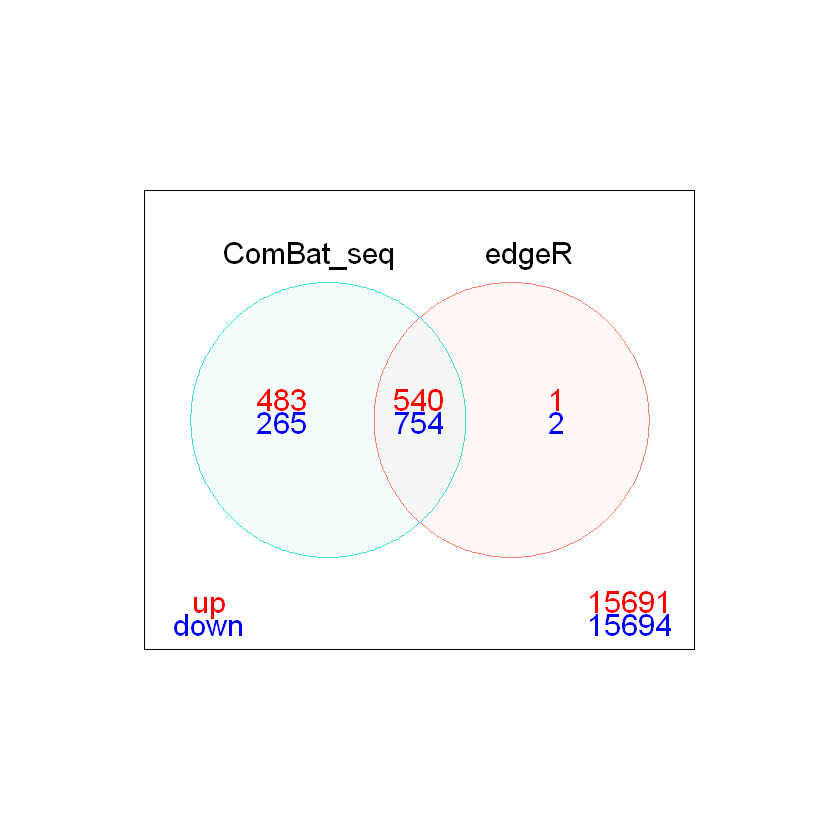

In [77]:
# Add another contrast to the contrasts matrix, check out the vennDiagram
# function c3 <- cbind(summa.fit.B, summa.fit.L)
head(c3)
vennDiagram(c3, include = c("up", "down"), names = c("ComBat_seq", "edgeR"), counts.col = c("red",
    "blue"), circle.col = c("turquoise", "salmon"))

## References
Michael I. Love, Simon Anders, and Wolfgang Huber. 2022. “Analyzing RNA-seq data with DESeq2.” Bioconductor, June. http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html.

Charity W. Law, Monther Alhamdoosh, Shian Su, Xueyi Dong1, Luyi Tian, Gordon K. Smyth, Matthew E. Ritchie. 2016. “RNA-seq analysis is easy as 1-2-3 with limma, Glimma and edgeR.” F1000Res May. https://f1000research.com/articles/5-1408.

Juan R Gonzalez. 2021. “Transciptomic analysis using limma and limma + voom pipelines.” RPubs by RStudio, May. https://rpubs.com/jrgonzalezISGlobal/transcriptomic_analyses.


## Session Info

In [78]:
sessionInfo()

R version 4.2.1 (2022-06-23 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22621)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.utf8 
[2] LC_CTYPE=English_United States.utf8   
[3] LC_MONETARY=English_United States.utf8
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.utf8    

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] forcats_0.5.2        stringr_1.4.1        dplyr_1.0.10        
 [4] purrr_0.3.4          readr_2.1.3          tidyr_1.2.1         
 [7] tibble_3.1.8         tidyverse_1.3.2      sva_3.44.0          
[10] BiocParallel_1.30.3  genefilter_1.78.0    mgcv_1.8-40         
[13] nlme_3.1-159         statmod_1.4.37       RColorBrewer_1.1-3  
[16] org.Mm.eg.db_3.15.0  AnnotationDbi_1.58.0 IRanges_2.30.0      
[19] S4Vectors_0.34.0     NMF_0.24.0           Biobase_2.56.0      
[22] BiocGeneri